<a href="https://colab.research.google.com/github/alexlin51/Neural_Network_DRP/blob/main/DogCatUpgrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -uq "/content/drive/My Drive/DataSets/CompPetImages.zip" -d "/content/PetImages"
!pip install optuna
!pip install plotly==4.14.3

In [ ]:
import plotly.graph_objects as go

In [ ]:
import os 
import cv2  
import numpy as np  
from tqdm.auto import tqdm, trange
import optuna  
import time

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the GPU


In [ ]:
DIR = os.getcwd()
REBUILD_DATA = True
try: 
  if os.path.exists(f"{DIR}/training_data.npy"):
    REBUILD_DATA = False  
except Exception as e:
  pass

print(REBUILD_DATA)

True


In [ ]:
PIXELS = 50
BATCH_SIZE = 100
EPOCHS = 12
CLASSES = 2

In [ ]:
class DogVsCats():
    
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catCount = 0  
    dogCount = 0  
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(f"{DIR}/PetImages/{label}")):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(f"{DIR}/PetImages/{path}", cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (PIXELS, PIXELS))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catCount += 1
                    elif label == self.DOGS:
                        self.dogCount += 1
                except Exception as e:
                    pass
                
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catCount)
        print("Dogs:", self.dogCount)
  

if REBUILD_DATA:
    dvc = DogVsCats()
    dvc.make_training_data()


Cats: 12476
Dogs: 12470


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [ ]:
print(len(training_data))

24946


In [ ]:
print(training_data[1])

[array([[227, 245, 251, ..., 254, 255, 252],
       [224, 176, 179, ..., 119, 123, 126],
       [ 88, 106, 105, ..., 102, 101, 108],
       ...,
       [ 99, 156,  37, ...,  58,  52,  55],
       [156,  46, 147, ...,  47,  64,  77],
       [108, 210, 195, ...,  59,  75,  50]], dtype=uint8)
 array([0., 1.])]


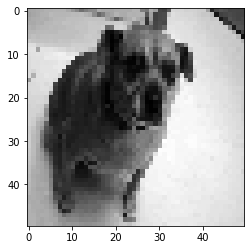

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(training_data[5][0], cmap="gray")
plt.show()

Complex layer = 1 -> 4
First - conv, bn, relu
Rest - conv, bn, relu, maxpool

Dense Layer = 1 -> 2 + 1

In [ ]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, PIXELS, PIXELS)
X = X/255.0  
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(test_X))

2494
22452 2494


In [ ]:
def define_model(trial):
  n_layers = trial.suggest_int("n_layers", 1, 4)
  layers = []

  in_features = 1
  after = False
  for i in range(n_layers):
    out_features = trial.suggest_int(f"n.{i}_layer_feature", 8, 128)
    kern = trial.suggest_int(f"n.{i}_kernSize", 1, 6)
    layers.append(nn.Conv2d(in_features, out_features, kern))
    m = trial.suggest_float(f"n.{i}_bn_m", 0.1, 0.2)
    layers.append(nn.BatchNorm2d(out_features, momentum=m))
    layers.append(nn.ReLU())
    
    if after:
      layers.append(nn.MaxPool2d((2,2)))
      p = trial.suggest_float(f"n.{i}_dropout_p", 0.2, 0.5)
      layers.append(nn.Dropout(p))
    else:
      after = True
    
    in_features = out_features

  layers.append(nn.Flatten())  
  m = nn.Sequential(*layers)
  input = torch.randn(1, 1, 50, 50)
  output = m(input).size()[1]
  in_features = output

  d_layers = trial.suggest_int("d_layers", 1, 2)
  for i in range(d_layers):
    out_features = trial.suggest_int(f"d.{i}_layer_features".format(i), 8, 1024)
    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.ReLU())

    in_features = out_features

  layers.append(nn.Linear(in_features, CLASSES))
  layers.append(nn.LogSoftmax(dim=1))
  
  set = nn.Sequential(*layers)
  print(set)
  return set


In [ ]:
def objective(trial):

  # Generate the model
  model = define_model(trial).to(device)

  # Find Optimizers
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam"])
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

  # Training of the model.
  for epoch in tqdm(range(EPOCHS), desc="Epochs Progress"):
    model.train()
    for i in range(0, len(train_X), BATCH_SIZE):
      batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,PIXELS,PIXELS)
      batch_y = train_y[i:i+BATCH_SIZE]
                
      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device) 

      optimizer.zero_grad()
      output = model(batch_X)
      output = torch.exp(output)
      loss = torch.nn.functional.mse_loss(output, batch_y)
      matches = [torch.argmax(i)==torch.argmax(j) for i, j in zip(output, batch_y)]
      acc = matches.count(True)/len(matches)     
      if i > len(train_X) - BATCH_SIZE:
        print(f"Loss: {loss}, Acc: {acc}, Epoch: {epoch + 1}")
      loss.backward()
      optimizer.step()
      
    model.eval()
    with torch.no_grad():
      batch_X = test_X.view(-1,1,PIXELS,PIXELS)
      batch_X = batch_X.to(device)
      batch_y = test_y.to(device) 

      output = model(batch_X)
      output = torch.exp(output)

      matches = [torch.argmax(i)==torch.argmax(j) for i, j in zip(output, batch_y)]
      valAcc = matches.count(True)/len(matches)      

    trial.report(valAcc, epoch) 

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()    

  return valAcc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(f"  Number of finished trials: {len(study.trials)}\n")
print(f"  Number of pruned trials: {len(pruned_trials)}\n")
print(f"  Number of complete trials: {len(complete_trials)}\n")

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}\n")

print("  Params: ")
for key, value in trial.params.items():
  print(f"    {key}: {value}\n")

[I 2021-02-01 19:46:19,252] A new study created in memory with name: no-name-78fd0cf2-6fcb-4dee-b5dd-225c83cfc5a0


Sequential(
  (0): Conv2d(1, 83, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(83, eps=1e-05, momentum=0.13139818361432584, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(83, 17, kernel_size=(5, 5), stride=(1, 1))
  (4): BatchNorm2d(17, eps=1e-05, momentum=0.16246285737591387, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.333895180456696, inplace=False)
  (8): Conv2d(17, 82, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(82, eps=1e-05, momentum=0.1493061602467305, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.33498893265728924, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6642, out_features=433, bias=True)
  (15): ReLU()
  (16): Linear(in_features=433, out_features=67, bias=True)

Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 2
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 3
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 4
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 5
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 6
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 7
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 8
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 9
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 10
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 11
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 12


[I 2021-02-01 19:48:22,283] Trial 0 finished with value: 0.49358460304731355 and parameters: {'n_layers': 3, 'n.0_layer_feature': 83, 'n.0_kernSize': 1, 'n.0_bn_m': 0.13139818361432584, 'n.1_layer_feature': 17, 'n.1_kernSize': 5, 'n.1_bn_m': 0.16246285737591387, 'n.1_dropout_p': 0.333895180456696, 'n.2_layer_feature': 82, 'n.2_kernSize': 6, 'n.2_bn_m': 0.1493061602467305, 'n.2_dropout_p': 0.33498893265728924, 'd_layers': 2, 'd.0_layer_features': 433, 'd.1_layer_features': 67, 'optimizer': 'Adam', 'lr': 0.010001272281780807}. Best is trial 0 with value: 0.49358460304731355.



Sequential(
  (0): Conv2d(1, 77, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(77, eps=1e-05, momentum=0.11301298839352501, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(77, 57, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(57, eps=1e-05, momentum=0.14688538424281938, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.44032130672222247, inplace=False)
  (8): Conv2d(57, 21, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(21, eps=1e-05, momentum=0.11559060569631027, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3865772369747693, inplace=False)
  (13): Conv2d(21, 44, kernel_size=(3, 3), stride=(1, 1))
  (14): BatchNorm2d(44, eps=1e-05, momentum=0.15498428606621723, affine=True, track_running_stats=True)
  (15): ReLU

Loss: 0.22677099704742432, Acc: 0.5384615384615384, Epoch: 1
Loss: 0.2054930478334427, Acc: 0.5769230769230769, Epoch: 2
Loss: 0.20486512780189514, Acc: 0.6923076923076923, Epoch: 3
Loss: 0.2014423906803131, Acc: 0.6153846153846154, Epoch: 4
Loss: 0.15576010942459106, Acc: 0.8076923076923077, Epoch: 5
Loss: 0.18020692467689514, Acc: 0.75, Epoch: 6
Loss: 0.15167318284511566, Acc: 0.8269230769230769, Epoch: 7
Loss: 0.14965084195137024, Acc: 0.7884615384615384, Epoch: 8
Loss: 0.14393268525600433, Acc: 0.7692307692307693, Epoch: 9
Loss: 0.12777702510356903, Acc: 0.8653846153846154, Epoch: 10
Loss: 0.17042303085327148, Acc: 0.7307692307692307, Epoch: 11
Loss: 0.16176849603652954, Acc: 0.8076923076923077, Epoch: 12


[I 2021-02-01 19:50:16,418] Trial 1 finished with value: 0.7967121090617482 and parameters: {'n_layers': 4, 'n.0_layer_feature': 77, 'n.0_kernSize': 1, 'n.0_bn_m': 0.11301298839352501, 'n.1_layer_feature': 57, 'n.1_kernSize': 3, 'n.1_bn_m': 0.14688538424281938, 'n.1_dropout_p': 0.44032130672222247, 'n.2_layer_feature': 21, 'n.2_kernSize': 3, 'n.2_bn_m': 0.11559060569631027, 'n.2_dropout_p': 0.3865772369747693, 'n.3_layer_feature': 44, 'n.3_kernSize': 3, 'n.3_bn_m': 0.15498428606621723, 'n.3_dropout_p': 0.3622819391602319, 'd_layers': 2, 'd.0_layer_features': 628, 'd.1_layer_features': 867, 'optimizer': 'Adam', 'lr': 0.0018137854636836716}. Best is trial 1 with value: 0.7967121090617482.



Sequential(
  (0): Conv2d(1, 45, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(45, eps=1e-05, momentum=0.12939334259835308, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(45, 74, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(74, eps=1e-05, momentum=0.1652281927751192, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.41726478944662065, inplace=False)
  (8): Conv2d(74, 97, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(97, eps=1e-05, momentum=0.14008155233540087, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4760369029164306, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=11737, out_features=284, bias=True)
  (15): ReLU()
  (16): Linear(in_features=284, out_features=2, bias=Tru

Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 1
Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 2
Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 3
Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 4
Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 5
Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 6
Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 7
Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 8
Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 9
Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 10
Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 11
Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 12


[I 2021-02-01 19:51:45,270] Trial 2 finished with value: 0.5064153969526864 and parameters: {'n_layers': 3, 'n.0_layer_feature': 45, 'n.0_kernSize': 1, 'n.0_bn_m': 0.12939334259835308, 'n.1_layer_feature': 74, 'n.1_kernSize': 1, 'n.1_bn_m': 0.1652281927751192, 'n.1_dropout_p': 0.41726478944662065, 'n.2_layer_feature': 97, 'n.2_kernSize': 3, 'n.2_bn_m': 0.14008155233540087, 'n.2_dropout_p': 0.4760369029164306, 'd_layers': 1, 'd.0_layer_features': 284, 'optimizer': 'Adam', 'lr': 0.011847084954178548}. Best is trial 1 with value: 0.7967121090617482.



Sequential(
  (0): Conv2d(1, 67, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(67, eps=1e-05, momentum=0.17714519936915946, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=167500, out_features=985, bias=True)
  (5): ReLU()
  (6): Linear(in_features=985, out_features=2, bias=True)
  (7): LogSoftmax(dim=1)
)


Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 2
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 3
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 4
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 5
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 6
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 7
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 8
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 9
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 10
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 11
Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 12


[I 2021-02-01 19:56:28,124] Trial 3 finished with value: 0.49358460304731355 and parameters: {'n_layers': 1, 'n.0_layer_feature': 67, 'n.0_kernSize': 1, 'n.0_bn_m': 0.17714519936915946, 'd_layers': 1, 'd.0_layer_features': 985, 'optimizer': 'Adam', 'lr': 0.0004732510735885821}. Best is trial 1 with value: 0.7967121090617482.



Sequential(
  (0): Conv2d(1, 85, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(85, eps=1e-05, momentum=0.17624620217891096, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(85, 107, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(107, eps=1e-05, momentum=0.15657510373005423, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3731595373304142, inplace=False)
  (8): Conv2d(107, 28, kernel_size=(1, 1), stride=(1, 1))
  (9): BatchNorm2d(28, eps=1e-05, momentum=0.19451442522915088, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.44948584513915385, inplace=False)
  (13): Conv2d(28, 30, kernel_size=(3, 3), stride=(1, 1))
  (14): BatchNorm2d(30, eps=1e-05, momentum=0.11428785352456045, affine=True, track_running_stats=True)
  (15): R

Loss: 0.229684978723526, Acc: 0.5769230769230769, Epoch: 1
Loss: 0.20756080746650696, Acc: 0.6538461538461539, Epoch: 2
Loss: 0.17103669047355652, Acc: 0.7307692307692307, Epoch: 3
Loss: 0.1842040866613388, Acc: 0.6538461538461539, Epoch: 4
Loss: 0.13467629253864288, Acc: 0.8653846153846154, Epoch: 5
Loss: 0.14886926114559174, Acc: 0.75, Epoch: 6
Loss: 0.14279864728450775, Acc: 0.7115384615384616, Epoch: 7
Loss: 0.141444131731987, Acc: 0.75, Epoch: 8
Loss: 0.13186544179916382, Acc: 0.8269230769230769, Epoch: 9
Loss: 0.12792208790779114, Acc: 0.8461538461538461, Epoch: 10
Loss: 0.14702539145946503, Acc: 0.8076923076923077, Epoch: 11
Loss: 0.10839193314313889, Acc: 0.8653846153846154, Epoch: 12


[I 2021-02-01 19:58:05,087] Trial 4 finished with value: 0.7052927024859663 and parameters: {'n_layers': 4, 'n.0_layer_feature': 85, 'n.0_kernSize': 4, 'n.0_bn_m': 0.17624620217891096, 'n.1_layer_feature': 107, 'n.1_kernSize': 1, 'n.1_bn_m': 0.15657510373005423, 'n.1_dropout_p': 0.3731595373304142, 'n.2_layer_feature': 28, 'n.2_kernSize': 1, 'n.2_bn_m': 0.19451442522915088, 'n.2_dropout_p': 0.44948584513915385, 'n.3_layer_feature': 30, 'n.3_kernSize': 3, 'n.3_bn_m': 0.11428785352456045, 'n.3_dropout_p': 0.2613024615399227, 'd_layers': 2, 'd.0_layer_features': 790, 'd.1_layer_features': 789, 'optimizer': 'Adam', 'lr': 0.0005625232864201622}. Best is trial 1 with value: 0.7967121090617482.



Sequential(
  (0): Conv2d(1, 96, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(96, eps=1e-05, momentum=0.15505235305899823, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(96, 99, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(99, eps=1e-05, momentum=0.10621088338986559, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.45369707950710325, inplace=False)
  (8): Conv2d(99, 117, kernel_size=(2, 2), stride=(1, 1))
  (9): BatchNorm2d(117, eps=1e-05, momentum=0.15561558022252153, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.26737906145089935, inplace=False)
  (13): Conv2d(117, 62, kernel_size=(2, 2), stride=(1, 1))
  (14): BatchNorm2d(62, eps=1e-05, momentum=0.10762621645887543, affine=True, track_running_stats=True)
  (15): 

Loss: 0.20366030931472778, Acc: 0.6923076923076923, Epoch: 1


[I 2021-02-01 19:58:18,881] Trial 5 pruned. 


Sequential(
  (0): Conv2d(1, 109, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(109, eps=1e-05, momentum=0.1865648769226541, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(109, 89, kernel_size=(6, 6), stride=(1, 1))
  (4): BatchNorm2d(89, eps=1e-05, momentum=0.11967710082328367, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.31465254940523313, inplace=False)
  (8): Conv2d(89, 121, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(121, eps=1e-05, momentum=0.1388133566753838, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4991862267682552, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=12100, out_features=343, bias=True)
  (15): ReLU()
  (16): Linear(in_features=343, out_features=363, bia

Loss: 0.1677282154560089, Acc: 0.75, Epoch: 1
Loss: 0.1460624486207962, Acc: 0.8076923076923077, Epoch: 2
Loss: 0.14331619441509247, Acc: 0.8076923076923077, Epoch: 3
Loss: 0.11575308442115784, Acc: 0.8076923076923077, Epoch: 4
Loss: 0.1360897272825241, Acc: 0.7692307692307693, Epoch: 5
Loss: 0.09459581971168518, Acc: 0.8076923076923077, Epoch: 6
Loss: 0.07970567792654037, Acc: 0.8653846153846154, Epoch: 7
Loss: 0.05744517967104912, Acc: 0.9423076923076923, Epoch: 8
Loss: 0.07365617156028748, Acc: 0.9230769230769231, Epoch: 9
Loss: 0.06260883808135986, Acc: 0.8846153846153846, Epoch: 10
Loss: 0.05487731471657753, Acc: 0.9038461538461539, Epoch: 11
Loss: 0.03527238965034485, Acc: 0.9615384615384616, Epoch: 12


[I 2021-02-01 20:01:41,145] Trial 6 finished with value: 0.7778668805132317 and parameters: {'n_layers': 3, 'n.0_layer_feature': 109, 'n.0_kernSize': 2, 'n.0_bn_m': 0.1865648769226541, 'n.1_layer_feature': 89, 'n.1_kernSize': 6, 'n.1_bn_m': 0.11967710082328367, 'n.1_dropout_p': 0.31465254940523313, 'n.2_layer_feature': 121, 'n.2_kernSize': 3, 'n.2_bn_m': 0.1388133566753838, 'n.2_dropout_p': 0.4991862267682552, 'd_layers': 2, 'd.0_layer_features': 343, 'd.1_layer_features': 363, 'optimizer': 'Adam', 'lr': 0.0001548530382889269}. Best is trial 1 with value: 0.7967121090617482.



Sequential(
  (0): Conv2d(1, 40, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(40, eps=1e-05, momentum=0.14785549246946067, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(40, 96, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(96, eps=1e-05, momentum=0.10326338853029741, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3327720185599079, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=50784, out_features=70, bias=True)
  (10): ReLU()
  (11): Linear(in_features=70, out_features=863, bias=True)
  (12): ReLU()
  (13): Linear(in_features=863, out_features=2, bias=True)
  (14): LogSoftmax(dim=1)
)


Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 1


[I 2021-02-01 20:01:47,785] Trial 7 pruned. 


Sequential(
  (0): Conv2d(1, 76, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(76, eps=1e-05, momentum=0.1799252601109721, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=160816, out_features=307, bias=True)
  (5): ReLU()
  (6): Linear(in_features=307, out_features=260, bias=True)
  (7): ReLU()
  (8): Linear(in_features=260, out_features=2, bias=True)
  (9): LogSoftmax(dim=1)
)


Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 1


[I 2021-02-01 20:01:58,372] Trial 8 pruned. 


Sequential(
  (0): Conv2d(1, 59, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(59, eps=1e-05, momentum=0.13096216671821098, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(59, 110, kernel_size=(6, 6), stride=(1, 1))
  (4): BatchNorm2d(110, eps=1e-05, momentum=0.11716693202342818, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.20735839247789778, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=53240, out_features=955, bias=True)
  (10): ReLU()
  (11): Linear(in_features=955, out_features=551, bias=True)
  (12): ReLU()
  (13): Linear(in_features=551, out_features=2, bias=True)
  (14): LogSoftmax(dim=1)
)


Loss: 0.19138285517692566, Acc: 0.7115384615384616, Epoch: 1
Loss: 0.17055678367614746, Acc: 0.8269230769230769, Epoch: 2
Loss: 0.14736729860305786, Acc: 0.8269230769230769, Epoch: 3
Loss: 0.12091102451086044, Acc: 0.8461538461538461, Epoch: 4
Loss: 0.09484373778104782, Acc: 0.8653846153846154, Epoch: 5
Loss: 0.05943934991955757, Acc: 0.9423076923076923, Epoch: 6
Loss: 0.04628913849592209, Acc: 0.9807692307692307, Epoch: 7
Loss: 0.04516984894871712, Acc: 0.9615384615384616, Epoch: 8
Loss: 0.11205179989337921, Acc: 0.8269230769230769, Epoch: 9
Loss: 0.025466438382864, Acc: 1.0, Epoch: 10
Loss: 0.03254930302500725, Acc: 1.0, Epoch: 11
Loss: 0.03507170081138611, Acc: 0.9807692307692307, Epoch: 12


[I 2021-02-01 20:06:00,706] Trial 9 finished with value: 0.7506014434643143 and parameters: {'n_layers': 2, 'n.0_layer_feature': 59, 'n.0_kernSize': 1, 'n.0_bn_m': 0.13096216671821098, 'n.1_layer_feature': 110, 'n.1_kernSize': 6, 'n.1_bn_m': 0.11716693202342818, 'n.1_dropout_p': 0.20735839247789778, 'd_layers': 2, 'd.0_layer_features': 955, 'd.1_layer_features': 551, 'optimizer': 'Adam', 'lr': 2.057183148150881e-05}. Best is trial 1 with value: 0.7967121090617482.



Sequential(
  (0): Conv2d(1, 127, kernel_size=(6, 6), stride=(1, 1))
  (1): BatchNorm2d(127, eps=1e-05, momentum=0.10717303883106746, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(127, 34, kernel_size=(4, 4), stride=(1, 1))
  (4): BatchNorm2d(34, eps=1e-05, momentum=0.13665929134911747, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.4979148103584884, inplace=False)
  (8): Conv2d(34, 11, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(11, eps=1e-05, momentum=0.10726775990621087, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3813170903849279, inplace=False)
  (13): Conv2d(11, 113, kernel_size=(6, 6), stride=(1, 1))
  (14): BatchNorm2d(113, eps=1e-05, momentum=0.1827310182754201, affine=True, track_running_stats=True)
  (15): R

Loss: 0.227875217795372, Acc: 0.6153846153846154, Epoch: 1
Loss: 0.22653067111968994, Acc: 0.6153846153846154, Epoch: 2


[I 2021-02-01 20:06:25,553] Trial 10 pruned. 


Sequential(
  (0): Conv2d(1, 116, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(116, eps=1e-05, momentum=0.19361557096914392, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(116, 65, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(65, eps=1e-05, momentum=0.1345093491528155, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2686965393134349, inplace=False)
  (8): Conv2d(65, 43, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(43, eps=1e-05, momentum=0.11461650330304199, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4970351435008898, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4300, out_features=599, bias=True)
  (15): ReLU()
  (16): Linear(in_features=599, out_features=412, bias=T

Loss: 0.20055192708969116, Acc: 0.6538461538461539, Epoch: 1
Loss: 0.1990668773651123, Acc: 0.7307692307692307, Epoch: 2
Loss: 0.17866824567317963, Acc: 0.6923076923076923, Epoch: 3
Loss: 0.12621092796325684, Acc: 0.8269230769230769, Epoch: 4
Loss: 0.1525835543870926, Acc: 0.7884615384615384, Epoch: 5
Loss: 0.1161806732416153, Acc: 0.8076923076923077, Epoch: 6
Loss: 0.12361763417720795, Acc: 0.8076923076923077, Epoch: 7
Loss: 0.11215731501579285, Acc: 0.8076923076923077, Epoch: 8
Loss: 0.08920862525701523, Acc: 0.8653846153846154, Epoch: 9
Loss: 0.08174904435873032, Acc: 0.8846153846153846, Epoch: 10
Loss: 0.0718361884355545, Acc: 0.9038461538461539, Epoch: 11
Loss: 0.0714169293642044, Acc: 0.8846153846153846, Epoch: 12


[I 2021-02-01 20:08:49,641] Trial 11 finished with value: 0.8352044907778668 and parameters: {'n_layers': 3, 'n.0_layer_feature': 116, 'n.0_kernSize': 2, 'n.0_bn_m': 0.19361557096914392, 'n.1_layer_feature': 65, 'n.1_kernSize': 3, 'n.1_bn_m': 0.1345093491528155, 'n.1_dropout_p': 0.2686965393134349, 'n.2_layer_feature': 43, 'n.2_kernSize': 4, 'n.2_bn_m': 0.11461650330304199, 'n.2_dropout_p': 0.4970351435008898, 'd_layers': 2, 'd.0_layer_features': 599, 'd.1_layer_features': 412, 'optimizer': 'Adam', 'lr': 0.0001110199687347481}. Best is trial 11 with value: 0.8352044907778668.



Sequential(
  (0): Conv2d(1, 15, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(15, eps=1e-05, momentum=0.10450764011977653, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(15, 51, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(51, eps=1e-05, momentum=0.19988207246978953, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.24179420699171394, inplace=False)
  (8): Conv2d(51, 43, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(43, eps=1e-05, momentum=0.10659601561726091, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3930549247004218, inplace=False)
  (13): Conv2d(43, 12, kernel_size=(5, 5), stride=(1, 1))
  (14): BatchNorm2d(12, eps=1e-05, momentum=0.1588997313314032, affine=True, track_running_stats=True)
  (15): ReLU(

Loss: 0.21815168857574463, Acc: 0.6346153846153846, Epoch: 1
Loss: 0.2074851095676422, Acc: 0.6923076923076923, Epoch: 2


[I 2021-02-01 20:09:00,616] Trial 12 pruned. 


Sequential(
  (0): Conv2d(1, 127, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(127, eps=1e-05, momentum=0.15570977794722254, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(127, 59, kernel_size=(4, 4), stride=(1, 1))
  (4): BatchNorm2d(59, eps=1e-05, momentum=0.13918532276689857, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.27277692557284333, inplace=False)
  (8): Conv2d(59, 46, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(46, eps=1e-05, momentum=0.1195560378795299, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.2874306547085778, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4600, out_features=765, bias=True)
  (15): ReLU()
  (16): Linear(in_features=765, out_features=954, bias=

Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1


[I 2021-02-01 20:09:13,697] Trial 13 pruned. 


Sequential(
  (0): Conv2d(1, 110, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(110, eps=1e-05, momentum=0.1982320764283476, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(110, 42, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(42, eps=1e-05, momentum=0.18223779590794698, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.4020715839433904, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=22218, out_features=575, bias=True)
  (10): ReLU()
  (11): Linear(in_features=575, out_features=316, bias=True)
  (12): ReLU()
  (13): Linear(in_features=316, out_features=2, bias=True)
  (14): LogSoftmax(dim=1)
)


Loss: 0.16723833978176117, Acc: 0.7307692307692307, Epoch: 1
Loss: 0.15965896844863892, Acc: 0.7692307692307693, Epoch: 2
Loss: 0.14508573710918427, Acc: 0.8076923076923077, Epoch: 3
Loss: 0.12276574969291687, Acc: 0.8461538461538461, Epoch: 4
Loss: 0.08552592247724533, Acc: 0.9038461538461539, Epoch: 5
Loss: 0.079320028424263, Acc: 0.9038461538461539, Epoch: 6
Loss: 0.06959396600723267, Acc: 0.9230769230769231, Epoch: 7
Loss: 0.05854082480072975, Acc: 0.9423076923076923, Epoch: 8
Loss: 0.13096556067466736, Acc: 0.8076923076923077, Epoch: 9
Loss: 0.031658101826906204, Acc: 0.9807692307692307, Epoch: 10
Loss: 0.017744142562150955, Acc: 0.9807692307692307, Epoch: 11
Loss: 0.03888368606567383, Acc: 0.9230769230769231, Epoch: 12


[I 2021-02-01 20:11:01,596] Trial 14 finished with value: 0.7582197273456295 and parameters: {'n_layers': 2, 'n.0_layer_feature': 110, 'n.0_kernSize': 3, 'n.0_bn_m': 0.1982320764283476, 'n.1_layer_feature': 42, 'n.1_kernSize': 2, 'n.1_bn_m': 0.18223779590794698, 'n.1_dropout_p': 0.4020715839433904, 'd_layers': 2, 'd.0_layer_features': 575, 'd.1_layer_features': 316, 'optimizer': 'Adam', 'lr': 0.00022284328314560383}. Best is trial 11 with value: 0.8352044907778668.



Sequential(
  (0): Conv2d(1, 104, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(104, eps=1e-05, momentum=0.11688097734023874, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(104, 74, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(74, eps=1e-05, momentum=0.14002054849304874, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2723890729381463, inplace=False)
  (8): Conv2d(74, 10, kernel_size=(2, 2), stride=(1, 1))
  (9): BatchNorm2d(10, eps=1e-05, momentum=0.12238654624493168, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.20732939157064162, inplace=False)
  (13): Conv2d(10, 62, kernel_size=(1, 1), stride=(1, 1))
  (14): BatchNorm2d(62, eps=1e-05, momentum=0.14430944976085214, affine=True, track_running_stats=True)
  (15): R

Loss: 0.2272699922323227, Acc: 0.5769230769230769, Epoch: 1


[I 2021-02-01 20:11:11,703] Trial 15 pruned. 


Sequential(
  (0): Conv2d(1, 10, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1973745486498073, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(10, 127, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(127, eps=1e-05, momentum=0.12639703001648311, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.48616350943599346, inplace=False)
  (8): Conv2d(127, 54, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(54, eps=1e-05, momentum=0.17440525658313932, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4278653366812687, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4374, out_features=482, bias=True)
  (15): ReLU()
  (16): Linear(in_features=482, out_features=450, bias=

Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1


[I 2021-02-01 20:11:22,180] Trial 16 pruned. 


Sequential(
  (0): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(50, eps=1e-05, momentum=0.16359236692154366, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(50, 65, kernel_size=(4, 4), stride=(1, 1))
  (4): BatchNorm2d(65, eps=1e-05, momentum=0.14941300349056036, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.20532478294803672, inplace=False)
  (8): Conv2d(65, 25, kernel_size=(2, 2), stride=(1, 1))
  (9): BatchNorm2d(25, eps=1e-05, momentum=0.11980261945159798, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.31754987013846325, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=2500, out_features=696, bias=True)
  (15): ReLU()
  (16): Linear(in_features=696, out_features=139, bias=T

Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 1


[I 2021-02-01 20:11:30,712] Trial 17 pruned. 


Sequential(
  (0): Conv2d(1, 25, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(25, eps=1e-05, momentum=0.11526945248512926, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(25, 29, kernel_size=(5, 5), stride=(1, 1))
  (4): BatchNorm2d(29, eps=1e-05, momentum=0.17293328762928747, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.4408736890678371, inplace=False)
  (8): Conv2d(29, 66, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(66, eps=1e-05, momentum=0.10437206979209279, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4129206303572576, inplace=False)
  (13): Conv2d(66, 97, kernel_size=(4, 4), stride=(1, 1))
  (14): BatchNorm2d(97, eps=1e-05, momentum=0.19815133608668156, affine=True, track_running_stats=True)
  (15): ReLU()

Loss: 0.24492855370044708, Acc: 0.5384615384615384, Epoch: 1


[I 2021-02-01 20:11:36,116] Trial 18 pruned. 


Sequential(
  (0): Conv2d(1, 117, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(117, eps=1e-05, momentum=0.1432134012472333, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(117, 9, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(9, eps=1e-05, momentum=0.14777368212295727, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2997138149622566, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=5184, out_features=531, bias=True)
  (10): ReLU()
  (11): Linear(in_features=531, out_features=2, bias=True)
  (12): LogSoftmax(dim=1)
)


Loss: 0.22645460069179535, Acc: 0.6153846153846154, Epoch: 1
Loss: 0.20620480179786682, Acc: 0.7115384615384616, Epoch: 2
Loss: 0.17974773049354553, Acc: 0.7884615384615384, Epoch: 3


[I 2021-02-01 20:11:53,448] Trial 19 pruned. 


Sequential(
  (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(96, eps=1e-05, momentum=0.16556374110040864, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(96, 83, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(83, eps=1e-05, momentum=0.1302679441884751, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.36502286804877876, inplace=False)
  (8): Conv2d(83, 31, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(31, eps=1e-05, momentum=0.13025829624129684, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.497747502327962, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3100, out_features=407, bias=True)
  (15): ReLU()
  (16): Linear(in_features=407, out_features=963, bias=True

Loss: 0.1775931715965271, Acc: 0.7307692307692307, Epoch: 1
Loss: 0.15563873946666718, Acc: 0.7692307692307693, Epoch: 2
Loss: 0.13415172696113586, Acc: 0.75, Epoch: 3
Loss: 0.09220157563686371, Acc: 0.8846153846153846, Epoch: 4
Loss: 0.11463142186403275, Acc: 0.8076923076923077, Epoch: 5
Loss: 0.09559796750545502, Acc: 0.8653846153846154, Epoch: 6
Loss: 0.08390963077545166, Acc: 0.8846153846153846, Epoch: 7
Loss: 0.09492506086826324, Acc: 0.8653846153846154, Epoch: 8
Loss: 0.06712834537029266, Acc: 0.9230769230769231, Epoch: 9
Loss: 0.07988041639328003, Acc: 0.9038461538461539, Epoch: 10
Loss: 0.0789317861199379, Acc: 0.8653846153846154, Epoch: 11
Loss: 0.0643937736749649, Acc: 0.9038461538461539, Epoch: 12


[I 2021-02-01 20:14:17,042] Trial 20 finished with value: 0.8243785084202085 and parameters: {'n_layers': 3, 'n.0_layer_feature': 96, 'n.0_kernSize': 3, 'n.0_bn_m': 0.16556374110040864, 'n.1_layer_feature': 83, 'n.1_kernSize': 3, 'n.1_bn_m': 0.1302679441884751, 'n.1_dropout_p': 0.36502286804877876, 'n.2_layer_feature': 31, 'n.2_kernSize': 4, 'n.2_bn_m': 0.13025829624129684, 'n.2_dropout_p': 0.497747502327962, 'd_layers': 2, 'd.0_layer_features': 407, 'd.1_layer_features': 963, 'optimizer': 'Adam', 'lr': 0.00025663668668126396}. Best is trial 11 with value: 0.8352044907778668.



Sequential(
  (0): Conv2d(1, 95, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(95, eps=1e-05, momentum=0.16604230104357065, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(95, 80, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(80, eps=1e-05, momentum=0.13233586283180868, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.37529189871173085, inplace=False)
  (8): Conv2d(80, 29, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(29, eps=1e-05, momentum=0.12822840536979457, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.48912125883795415, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=2900, out_features=400, bias=True)
  (15): ReLU()
  (16): Linear(in_features=400, out_features=1012, bias

Loss: 0.18946748971939087, Acc: 0.7115384615384616, Epoch: 1
Loss: 0.18104557693004608, Acc: 0.6923076923076923, Epoch: 2
Loss: 0.13478031754493713, Acc: 0.7692307692307693, Epoch: 3
Loss: 0.12322013825178146, Acc: 0.8269230769230769, Epoch: 4
Loss: 0.08749222755432129, Acc: 0.8653846153846154, Epoch: 5
Loss: 0.0936439037322998, Acc: 0.8461538461538461, Epoch: 6
Loss: 0.07908187806606293, Acc: 0.9038461538461539, Epoch: 7
Loss: 0.0793895497918129, Acc: 0.8846153846153846, Epoch: 8
Loss: 0.07095279544591904, Acc: 0.9038461538461539, Epoch: 9
Loss: 0.09120725095272064, Acc: 0.8461538461538461, Epoch: 10
Loss: 0.05875183641910553, Acc: 0.9615384615384616, Epoch: 11
Loss: 0.04847249016165733, Acc: 0.9423076923076923, Epoch: 12


[I 2021-02-01 20:16:36,636] Trial 21 finished with value: 0.8376102646351243 and parameters: {'n_layers': 3, 'n.0_layer_feature': 95, 'n.0_kernSize': 3, 'n.0_bn_m': 0.16604230104357065, 'n.1_layer_feature': 80, 'n.1_kernSize': 3, 'n.1_bn_m': 0.13233586283180868, 'n.1_dropout_p': 0.37529189871173085, 'n.2_layer_feature': 29, 'n.2_kernSize': 4, 'n.2_bn_m': 0.12822840536979457, 'n.2_dropout_p': 0.48912125883795415, 'd_layers': 2, 'd.0_layer_features': 400, 'd.1_layer_features': 1012, 'optimizer': 'Adam', 'lr': 0.00029266336455205383}. Best is trial 21 with value: 0.8376102646351243.



Sequential(
  (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(96, eps=1e-05, momentum=0.1670843400921305, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(96, 79, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(79, eps=1e-05, momentum=0.1278575897454775, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3676763864543684, inplace=False)
  (8): Conv2d(79, 33, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(33, eps=1e-05, momentum=0.13336249122864322, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4927474931402576, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3300, out_features=402, bias=True)
  (15): ReLU()
  (16): Linear(in_features=402, out_features=934, bias=True

Loss: 0.16927646100521088, Acc: 0.6923076923076923, Epoch: 1
Loss: 0.14955034852027893, Acc: 0.7692307692307693, Epoch: 2
Loss: 0.13730697333812714, Acc: 0.8076923076923077, Epoch: 3
Loss: 0.1037086769938469, Acc: 0.8653846153846154, Epoch: 4
Loss: 0.10156650096178055, Acc: 0.8269230769230769, Epoch: 5
Loss: 0.10596253722906113, Acc: 0.8461538461538461, Epoch: 6
Loss: 0.10106097906827927, Acc: 0.8461538461538461, Epoch: 7
Loss: 0.09444496035575867, Acc: 0.8653846153846154, Epoch: 8
Loss: 0.0704866275191307, Acc: 0.8846153846153846, Epoch: 9
Loss: 0.05357672646641731, Acc: 0.9423076923076923, Epoch: 10
Loss: 0.04624420404434204, Acc: 0.9423076923076923, Epoch: 11
Loss: 0.0466221421957016, Acc: 0.9615384615384616, Epoch: 12


[I 2021-02-01 20:18:58,025] Trial 22 finished with value: 0.842822774659182 and parameters: {'n_layers': 3, 'n.0_layer_feature': 96, 'n.0_kernSize': 3, 'n.0_bn_m': 0.1670843400921305, 'n.1_layer_feature': 79, 'n.1_kernSize': 3, 'n.1_bn_m': 0.1278575897454775, 'n.1_dropout_p': 0.3676763864543684, 'n.2_layer_feature': 33, 'n.2_kernSize': 4, 'n.2_bn_m': 0.13336249122864322, 'n.2_dropout_p': 0.4927474931402576, 'd_layers': 2, 'd.0_layer_features': 402, 'd.1_layer_features': 934, 'optimizer': 'Adam', 'lr': 0.00027096886234174956}. Best is trial 22 with value: 0.842822774659182.



Sequential(
  (0): Conv2d(1, 94, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(94, eps=1e-05, momentum=0.16693501971615515, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(94, 82, kernel_size=(4, 4), stride=(1, 1))
  (4): BatchNorm2d(82, eps=1e-05, momentum=0.1157161212405544, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.39063211039971735, inplace=False)
  (8): Conv2d(82, 41, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(41, eps=1e-05, momentum=0.13206193879166023, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4750336829829688, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3321, out_features=135, bias=True)
  (15): ReLU()
  (16): Linear(in_features=135, out_features=1022, bias=T

Loss: 0.2045925259590149, Acc: 0.6346153846153846, Epoch: 1


[I 2021-02-01 20:19:12,005] Trial 23 pruned. 


Sequential(
  (0): Conv2d(1, 123, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(123, eps=1e-05, momentum=0.18822119274282637, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(123, 71, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(71, eps=1e-05, momentum=0.12811752782974375, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.34973425596377095, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=34364, out_features=210, bias=True)
  (10): ReLU()
  (11): Linear(in_features=210, out_features=437, bias=True)
  (12): ReLU()
  (13): Linear(in_features=437, out_features=2, bias=True)
  (14): LogSoftmax(dim=1)
)


Loss: 0.18120898306369781, Acc: 0.7115384615384616, Epoch: 1
Loss: 0.14969365298748016, Acc: 0.8076923076923077, Epoch: 2
Loss: 0.14108304679393768, Acc: 0.8269230769230769, Epoch: 3
Loss: 0.12923263013362885, Acc: 0.7692307692307693, Epoch: 4
Loss: 0.1269340217113495, Acc: 0.8461538461538461, Epoch: 5
Loss: 0.07236745953559875, Acc: 0.9423076923076923, Epoch: 6
Loss: 0.08958005160093307, Acc: 0.9038461538461539, Epoch: 7
Loss: 0.07824422419071198, Acc: 0.8846153846153846, Epoch: 8
Loss: 0.06979039311408997, Acc: 0.9038461538461539, Epoch: 9
Loss: 0.05407678335905075, Acc: 0.9423076923076923, Epoch: 10
Loss: 0.04430124908685684, Acc: 0.9807692307692307, Epoch: 11
Loss: 0.04040832445025444, Acc: 0.9807692307692307, Epoch: 12


[I 2021-02-01 20:21:29,162] Trial 24 finished with value: 0.7786688051323175 and parameters: {'n_layers': 2, 'n.0_layer_feature': 123, 'n.0_kernSize': 5, 'n.0_bn_m': 0.18822119274282637, 'n.1_layer_feature': 71, 'n.1_kernSize': 2, 'n.1_bn_m': 0.12811752782974375, 'n.1_dropout_p': 0.34973425596377095, 'd_layers': 2, 'd.0_layer_features': 210, 'd.1_layer_features': 437, 'optimizer': 'Adam', 'lr': 3.2692685004148244e-05}. Best is trial 22 with value: 0.842822774659182.



Sequential(
  (0): Conv2d(1, 114, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(114, eps=1e-05, momentum=0.19047895352125857, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(114, 49, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(49, eps=1e-05, momentum=0.1118738805572716, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2887314152466972, inplace=False)
  (8): Conv2d(49, 60, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(60, eps=1e-05, momentum=0.15617753701651724, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4584143090208329, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3840, out_features=405, bias=True)
  (15): ReLU()
  (16): Linear(in_features=405, out_features=1014, bias

Loss: 0.17107270658016205, Acc: 0.75, Epoch: 1


[I 2021-02-01 20:21:40,513] Trial 25 pruned. 


Sequential(
  (0): Conv2d(1, 101, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(101, eps=1e-05, momentum=0.17044237696936615, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(101, 81, kernel_size=(5, 5), stride=(1, 1))
  (4): BatchNorm2d(81, eps=1e-05, momentum=0.13263242540390124, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.24536385192201277, inplace=False)
  (8): Conv2d(81, 37, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(37, eps=1e-05, momentum=0.13127652774543347, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4954423768647629, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=2997, out_features=498, bias=True)
  (15): ReLU()
  (16): Linear(in_features=498, out_features=217, bias

Loss: 0.19520939886569977, Acc: 0.7307692307692307, Epoch: 1


[I 2021-02-01 20:21:54,824] Trial 26 pruned. 


Sequential(
  (0): Conv2d(1, 88, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(88, eps=1e-05, momentum=0.13885424236788657, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(88, 120, kernel_size=(4, 4), stride=(1, 1))
  (4): BatchNorm2d(120, eps=1e-05, momentum=0.12325348015089983, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3732626290905888, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=58080, out_features=226, bias=True)
  (10): ReLU()
  (11): Linear(in_features=226, out_features=708, bias=True)
  (12): ReLU()
  (13): Linear(in_features=708, out_features=2, bias=True)
  (14): LogSoftmax(dim=1)
)


Loss: 0.20935876667499542, Acc: 0.6538461538461539, Epoch: 1


[I 2021-02-01 20:22:11,487] Trial 27 pruned. 


Sequential(
  (0): Conv2d(1, 118, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(118, eps=1e-05, momentum=0.1562463843894908, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(118, 63, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(63, eps=1e-05, momentum=0.14245999114107347, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.4094108833916666, inplace=False)
  (8): Conv2d(63, 17, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(17, eps=1e-05, momentum=0.14388662293084195, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.43925866167845673, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1377, out_features=351, bias=True)
  (15): ReLU()
  (16): Linear(in_features=351, out_features=901, bias=

Loss: 0.21656781435012817, Acc: 0.6538461538461539, Epoch: 1
Loss: 0.1706296056509018, Acc: 0.7115384615384616, Epoch: 2
Loss: 0.1495545208454132, Acc: 0.7692307692307693, Epoch: 3
Loss: 0.12546129524707794, Acc: 0.8076923076923077, Epoch: 4
Loss: 0.10503783077001572, Acc: 0.8461538461538461, Epoch: 5
Loss: 0.13550356030464172, Acc: 0.8269230769230769, Epoch: 6
Loss: 0.0955524742603302, Acc: 0.8461538461538461, Epoch: 7
Loss: 0.09467262774705887, Acc: 0.8461538461538461, Epoch: 8
Loss: 0.09847710281610489, Acc: 0.8269230769230769, Epoch: 9
Loss: 0.07302985340356827, Acc: 0.9423076923076923, Epoch: 10
Loss: 0.0627804771065712, Acc: 0.9423076923076923, Epoch: 11
Loss: 0.04886159300804138, Acc: 0.9615384615384616, Epoch: 12


[I 2021-02-01 20:24:05,927] Trial 28 finished with value: 0.8067361668003208 and parameters: {'n_layers': 3, 'n.0_layer_feature': 118, 'n.0_kernSize': 5, 'n.0_bn_m': 0.1562463843894908, 'n.1_layer_feature': 63, 'n.1_kernSize': 2, 'n.1_bn_m': 0.14245999114107347, 'n.1_dropout_p': 0.4094108833916666, 'n.2_layer_feature': 17, 'n.2_kernSize': 4, 'n.2_bn_m': 0.14388662293084195, 'n.2_dropout_p': 0.43925866167845673, 'd_layers': 2, 'd.0_layer_features': 351, 'd.1_layer_features': 901, 'optimizer': 'Adam', 'lr': 0.00035534215567004557}. Best is trial 22 with value: 0.842822774659182.



Sequential(
  (0): Conv2d(1, 82, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(82, eps=1e-05, momentum=0.18239390248044732, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(82, 93, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(93, eps=1e-05, momentum=0.11089049607496167, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3404810103274445, inplace=False)
  (8): Conv2d(93, 78, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(78, eps=1e-05, momentum=0.16514502720335184, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.49982167020597407, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=7800, out_features=452, bias=True)
  (15): ReLU()
  (16): Linear(in_features=452, out_features=470, bias=T

Loss: 0.14046712219715118, Acc: 0.8461538461538461, Epoch: 1
Loss: 0.12684457004070282, Acc: 0.8269230769230769, Epoch: 2
Loss: 0.14863839745521545, Acc: 0.7884615384615384, Epoch: 3
Loss: 0.10621505975723267, Acc: 0.8461538461538461, Epoch: 4
Loss: 0.1027916967868805, Acc: 0.8846153846153846, Epoch: 5
Loss: 0.09064017236232758, Acc: 0.8653846153846154, Epoch: 6
Loss: 0.0996299535036087, Acc: 0.8653846153846154, Epoch: 7
Loss: 0.09382755309343338, Acc: 0.8653846153846154, Epoch: 8
Loss: 0.03868716582655907, Acc: 0.9615384615384616, Epoch: 9
Loss: 0.049886733293533325, Acc: 0.9423076923076923, Epoch: 10
Loss: 0.030117755755782127, Acc: 0.9615384615384616, Epoch: 11
Loss: 0.042467448860406876, Acc: 0.9423076923076923, Epoch: 12


[I 2021-02-01 20:26:45,436] Trial 29 finished with value: 0.8119486768243785 and parameters: {'n_layers': 3, 'n.0_layer_feature': 82, 'n.0_kernSize': 2, 'n.0_bn_m': 0.18239390248044732, 'n.1_layer_feature': 93, 'n.1_kernSize': 3, 'n.1_bn_m': 0.11089049607496167, 'n.1_dropout_p': 0.3404810103274445, 'n.2_layer_feature': 78, 'n.2_kernSize': 3, 'n.2_bn_m': 0.16514502720335184, 'n.2_dropout_p': 0.49982167020597407, 'd_layers': 2, 'd.0_layer_features': 452, 'd.1_layer_features': 470, 'optimizer': 'Adam', 'lr': 0.0009756511167435729}. Best is trial 22 with value: 0.842822774659182.



Sequential(
  (0): Conv2d(1, 71, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(71, eps=1e-05, momentum=0.17233719979767337, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(71, 103, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(103, eps=1e-05, momentum=0.15508902622893725, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.31285584774494446, inplace=False)
  (8): Conv2d(103, 53, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(53, eps=1e-05, momentum=0.11329396432646163, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4703249531212521, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5300, out_features=550, bias=True)
  (15): ReLU()
  (16): Linear(in_features=550, out_features=2, bias=

Loss: 0.19482702016830444, Acc: 0.7115384615384616, Epoch: 1
Loss: 0.17310307919979095, Acc: 0.6730769230769231, Epoch: 2
Loss: 0.17818139493465424, Acc: 0.7307692307692307, Epoch: 3
Loss: 0.1574259251356125, Acc: 0.7307692307692307, Epoch: 4
Loss: 0.13075941801071167, Acc: 0.8076923076923077, Epoch: 5
Loss: 0.12461541593074799, Acc: 0.8461538461538461, Epoch: 6
Loss: 0.10597207397222519, Acc: 0.8076923076923077, Epoch: 7
Loss: 0.1010555624961853, Acc: 0.8461538461538461, Epoch: 8
Loss: 0.08519245684146881, Acc: 0.9038461538461539, Epoch: 9
Loss: 0.08215361833572388, Acc: 0.8846153846153846, Epoch: 10
Loss: 0.057183727622032166, Acc: 0.9615384615384616, Epoch: 11
Loss: 0.044540438801050186, Acc: 0.9615384615384616, Epoch: 12


[I 2021-02-01 20:28:32,207] Trial 30 finished with value: 0.8199679230152366 and parameters: {'n_layers': 3, 'n.0_layer_feature': 71, 'n.0_kernSize': 3, 'n.0_bn_m': 0.17233719979767337, 'n.1_layer_feature': 103, 'n.1_kernSize': 1, 'n.1_bn_m': 0.15508902622893725, 'n.1_dropout_p': 0.31285584774494446, 'n.2_layer_feature': 53, 'n.2_kernSize': 5, 'n.2_bn_m': 0.11329396432646163, 'n.2_dropout_p': 0.4703249531212521, 'd_layers': 1, 'd.0_layer_features': 550, 'optimizer': 'Adam', 'lr': 0.00015644123843126773}. Best is trial 22 with value: 0.842822774659182.



Sequential(
  (0): Conv2d(1, 92, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(92, eps=1e-05, momentum=0.16278528447461535, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(92, 82, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(82, eps=1e-05, momentum=0.13152248204222794, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.370002773423548, inplace=False)
  (8): Conv2d(82, 30, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(30, eps=1e-05, momentum=0.12914177202547952, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4974379459544093, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3000, out_features=403, bias=True)
  (15): ReLU()
  (16): Linear(in_features=403, out_features=997, bias=Tru

Loss: 0.18856371939182281, Acc: 0.75, Epoch: 1


[I 2021-02-01 20:28:44,139] Trial 31 pruned. 


Sequential(
  (0): Conv2d(1, 103, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(103, eps=1e-05, momentum=0.16362156178498105, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(103, 88, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(88, eps=1e-05, momentum=0.13315549712741614, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3687037120184697, inplace=False)
  (8): Conv2d(88, 35, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(35, eps=1e-05, momentum=0.12742677277107464, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.49890147476666874, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3500, out_features=421, bias=True)
  (15): ReLU()
  (16): Linear(in_features=421, out_features=813, bias

Loss: 0.18112397193908691, Acc: 0.7115384615384616, Epoch: 1


[I 2021-02-01 20:28:56,949] Trial 32 pruned. 


Sequential(
  (0): Conv2d(1, 98, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(98, eps=1e-05, momentum=0.15895794973776028, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(98, 76, kernel_size=(4, 4), stride=(1, 1))
  (4): BatchNorm2d(76, eps=1e-05, momentum=0.12464269539941643, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.33315733554696825, inplace=False)
  (8): Conv2d(76, 8, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(8, eps=1e-05, momentum=0.133403721187175, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4825401419195568, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=648, out_features=256, bias=True)
  (15): ReLU()
  (16): Linear(in_features=256, out_features=939, bias=True)
 

Loss: 0.19376084208488464, Acc: 0.6730769230769231, Epoch: 1


[I 2021-02-01 20:29:10,670] Trial 33 pruned. 


Sequential(
  (0): Conv2d(1, 107, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(107, eps=1e-05, momentum=0.1478467495983921, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(107, 67, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(67, eps=1e-05, momentum=0.1447931450060887, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.38596981333086894, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=35443, out_features=357, bias=True)
  (10): ReLU()
  (11): Linear(in_features=357, out_features=1023, bias=True)
  (12): ReLU()
  (13): Linear(in_features=1023, out_features=2, bias=True)
  (14): LogSoftmax(dim=1)
)


Loss: 0.18138565123081207, Acc: 0.7307692307692307, Epoch: 1
Loss: 0.15136337280273438, Acc: 0.7884615384615384, Epoch: 2
Loss: 0.11786577105522156, Acc: 0.7884615384615384, Epoch: 3
Loss: 0.1177423968911171, Acc: 0.75, Epoch: 4
Loss: 0.07798045873641968, Acc: 0.9423076923076923, Epoch: 5
Loss: 0.06979858130216599, Acc: 0.9038461538461539, Epoch: 6
Loss: 0.05864553153514862, Acc: 0.9230769230769231, Epoch: 7
Loss: 0.04436688870191574, Acc: 0.9807692307692307, Epoch: 8
Loss: 0.02490398846566677, Acc: 1.0, Epoch: 9
Loss: 0.03693413734436035, Acc: 1.0, Epoch: 10
Loss: 0.021031050011515617, Acc: 1.0, Epoch: 11


[I 2021-02-01 20:31:23,269] Trial 34 pruned. 


Sequential(
  (0): Conv2d(1, 81, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(81, eps=1e-05, momentum=0.17220006261732546, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(81, 54, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(54, eps=1e-05, momentum=0.13519590120624123, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3559154577902551, inplace=False)
  (8): Conv2d(54, 50, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(50, eps=1e-05, momentum=0.12484113851043871, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.45410867646834796, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5000, out_features=710, bias=True)
  (15): ReLU()
  (16): Linear(in_features=710, out_features=623, bias=Tr

Loss: 0.16101065278053284, Acc: 0.7307692307692307, Epoch: 1
Loss: 0.15100999176502228, Acc: 0.8269230769230769, Epoch: 2
Loss: 0.12432589381933212, Acc: 0.8461538461538461, Epoch: 3
Loss: 0.12209168076515198, Acc: 0.8269230769230769, Epoch: 4
Loss: 0.10717473924160004, Acc: 0.8461538461538461, Epoch: 5
Loss: 0.09657108038663864, Acc: 0.8653846153846154, Epoch: 6
Loss: 0.07999740540981293, Acc: 0.9038461538461539, Epoch: 7
Loss: 0.07310167700052261, Acc: 0.9230769230769231, Epoch: 8
Loss: 0.07145371288061142, Acc: 0.9230769230769231, Epoch: 9
Loss: 0.04117297753691673, Acc: 1.0, Epoch: 10
Loss: 0.061053525656461716, Acc: 0.9038461538461539, Epoch: 11
Loss: 0.037714358419179916, Acc: 0.9423076923076923, Epoch: 12


[I 2021-02-01 20:33:20,865] Trial 35 finished with value: 0.7902967121090617 and parameters: {'n_layers': 3, 'n.0_layer_feature': 81, 'n.0_kernSize': 3, 'n.0_bn_m': 0.17220006261732546, 'n.1_layer_feature': 54, 'n.1_kernSize': 3, 'n.1_bn_m': 0.13519590120624123, 'n.1_dropout_p': 0.3559154577902551, 'n.2_layer_feature': 50, 'n.2_kernSize': 3, 'n.2_bn_m': 0.12484113851043871, 'n.2_dropout_p': 0.45410867646834796, 'd_layers': 2, 'd.0_layer_features': 710, 'd.1_layer_features': 623, 'optimizer': 'Adam', 'lr': 0.0004314608719206589}. Best is trial 22 with value: 0.842822774659182.



Sequential(
  (0): Conv2d(1, 90, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(90, eps=1e-05, momentum=0.19215914667998155, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(90, 87, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(87, eps=1e-05, momentum=0.1555017270422025, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.4299005248447614, inplace=False)
  (8): Conv2d(87, 20, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(20, eps=1e-05, momentum=0.11326936030903388, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.42267560393233145, inplace=False)
  (13): Conv2d(20, 127, kernel_size=(6, 6), stride=(1, 1))
  (14): BatchNorm2d(127, eps=1e-05, momentum=0.13014118110676753, affine=True, track_running_stats=True)
  (15): ReL

Loss: 0.2009870857000351, Acc: 0.6730769230769231, Epoch: 1


[I 2021-02-01 20:33:31,455] Trial 36 pruned. 


Sequential(
  (0): Conv2d(1, 66, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(66, eps=1e-05, momentum=0.1752345201048091, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(66, 77, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(77, eps=1e-05, momentum=0.12166881349890313, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.38654246841352996, inplace=False)
  (8): Conv2d(77, 33, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(33, eps=1e-05, momentum=0.13808438436821896, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4718433038101507, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3300, out_features=461, bias=True)
  (15): ReLU()
  (16): Linear(in_features=461, out_features=391, bias=Tru

Loss: 0.16069629788398743, Acc: 0.75, Epoch: 1
Loss: 0.13375939428806305, Acc: 0.8076923076923077, Epoch: 2
Loss: 0.11840738356113434, Acc: 0.8269230769230769, Epoch: 3
Loss: 0.11750321090221405, Acc: 0.8461538461538461, Epoch: 4
Loss: 0.08827757835388184, Acc: 0.9038461538461539, Epoch: 5
Loss: 0.11173549294471741, Acc: 0.8269230769230769, Epoch: 6
Loss: 0.07843106985092163, Acc: 0.8846153846153846, Epoch: 7
Loss: 0.07706519216299057, Acc: 0.9038461538461539, Epoch: 8
Loss: 0.047011423856019974, Acc: 0.9615384615384616, Epoch: 9
Loss: 0.049411602318286896, Acc: 0.9423076923076923, Epoch: 10
Loss: 0.054515913128852844, Acc: 0.9230769230769231, Epoch: 11
Loss: 0.022016601637005806, Acc: 0.9807692307692307, Epoch: 12


[I 2021-02-01 20:35:47,122] Trial 37 finished with value: 0.8508420208500401 and parameters: {'n_layers': 3, 'n.0_layer_feature': 66, 'n.0_kernSize': 3, 'n.0_bn_m': 0.1752345201048091, 'n.1_layer_feature': 77, 'n.1_kernSize': 3, 'n.1_bn_m': 0.12166881349890313, 'n.1_dropout_p': 0.38654246841352996, 'n.2_layer_feature': 33, 'n.2_kernSize': 4, 'n.2_bn_m': 0.13808438436821896, 'n.2_dropout_p': 0.4718433038101507, 'd_layers': 2, 'd.0_layer_features': 461, 'd.1_layer_features': 391, 'optimizer': 'Adam', 'lr': 0.0005483891205075865}. Best is trial 37 with value: 0.8508420208500401.



Sequential(
  (0): Conv2d(1, 63, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(63, eps=1e-05, momentum=0.18339956657057616, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(63, 75, kernel_size=(4, 4), stride=(1, 1))
  (4): BatchNorm2d(75, eps=1e-05, momentum=0.12027988520235289, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3905599376834288, inplace=False)
  (8): Conv2d(75, 37, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(37, eps=1e-05, momentum=0.1467382361867807, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4670953417394955, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3700, out_features=486, bias=True)
  (15): ReLU()
  (16): Linear(in_features=486, out_features=364, bias=Tru

Loss: 0.20885489881038666, Acc: 0.6538461538461539, Epoch: 1


[I 2021-02-01 20:35:58,504] Trial 38 pruned. 


Sequential(
  (0): Conv2d(1, 52, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(52, eps=1e-05, momentum=0.17597326130397795, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(52, 69, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(69, eps=1e-05, momentum=0.10805572289916222, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.4682949405431749, inplace=False)
  (8): Conv2d(69, 60, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(60, eps=1e-05, momentum=0.13866929977157713, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.44284651549639065, inplace=False)
  (13): Conv2d(60, 90, kernel_size=(1, 1), stride=(1, 1))
  (14): BatchNorm2d(90, eps=1e-05, momentum=0.17952257443467362, affine=True, track_running_stats=True)
  (15): ReLU(

Loss: 0.19257989525794983, Acc: 0.7115384615384616, Epoch: 1


[I 2021-02-01 20:36:05,734] Trial 39 pruned. 


Sequential(
  (0): Conv2d(1, 73, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(73, eps=1e-05, momentum=0.19412324005980358, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(73, 60, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(60, eps=1e-05, momentum=0.11565827023132963, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.41146729536333737, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=29040, out_features=535, bias=True)
  (10): ReLU()
  (11): Linear(in_features=535, out_features=2, bias=True)
  (12): LogSoftmax(dim=1)
)


Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1


[I 2021-02-01 20:36:15,618] Trial 40 pruned. 


Sequential(
  (0): Conv2d(1, 67, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(67, eps=1e-05, momentum=0.15141678921168605, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(67, 80, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(80, eps=1e-05, momentum=0.10063827043977921, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.35322615611139546, inplace=False)
  (8): Conv2d(80, 33, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(33, eps=1e-05, momentum=0.15187343546493354, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4816462863630484, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3300, out_features=299, bias=True)
  (15): ReLU()
  (16): Linear(in_features=299, out_features=496, bias=Tr

Loss: 0.1803438514471054, Acc: 0.7115384615384616, Epoch: 1


[I 2021-02-01 20:36:26,960] Trial 41 pruned. 


Sequential(
  (0): Conv2d(1, 81, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(81, eps=1e-05, momentum=0.1665122181252613, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(81, 95, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(95, eps=1e-05, momentum=0.1291186693792606, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3199399334707399, inplace=False)
  (8): Conv2d(95, 17, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(17, eps=1e-05, momentum=0.13447227690035338, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.49983369341483663, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1700, out_features=377, bias=True)
  (15): ReLU()
  (16): Linear(in_features=377, out_features=308, bias=True

Loss: 0.19109021127223969, Acc: 0.7115384615384616, Epoch: 1
Loss: 0.17572344839572906, Acc: 0.7115384615384616, Epoch: 2
Loss: 0.14251483976840973, Acc: 0.8076923076923077, Epoch: 3
Loss: 0.14220115542411804, Acc: 0.7884615384615384, Epoch: 4
Loss: 0.1277220994234085, Acc: 0.7884615384615384, Epoch: 5
Loss: 0.10629300028085709, Acc: 0.8846153846153846, Epoch: 6
Loss: 0.1289435476064682, Acc: 0.8076923076923077, Epoch: 7
Loss: 0.10934705287218094, Acc: 0.8653846153846154, Epoch: 8
Loss: 0.11342522501945496, Acc: 0.8269230769230769, Epoch: 9
Loss: 0.08660745620727539, Acc: 0.9038461538461539, Epoch: 10
Loss: 0.08681955933570862, Acc: 0.8653846153846154, Epoch: 11
Loss: 0.08934006839990616, Acc: 0.8846153846153846, Epoch: 12


[I 2021-02-01 20:38:50,243] Trial 42 finished with value: 0.8311948676824379 and parameters: {'n_layers': 3, 'n.0_layer_feature': 81, 'n.0_kernSize': 3, 'n.0_bn_m': 0.1665122181252613, 'n.1_layer_feature': 95, 'n.1_kernSize': 3, 'n.1_bn_m': 0.1291186693792606, 'n.1_dropout_p': 0.3199399334707399, 'n.2_layer_feature': 17, 'n.2_kernSize': 4, 'n.2_bn_m': 0.13447227690035338, 'n.2_dropout_p': 0.49983369341483663, 'd_layers': 2, 'd.0_layer_features': 377, 'd.1_layer_features': 308, 'optimizer': 'Adam', 'lr': 0.00011160541781923562}. Best is trial 37 with value: 0.8508420208500401.



Sequential(
  (0): Conv2d(1, 80, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(80, eps=1e-05, momentum=0.17511334940102444, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(80, 114, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(114, eps=1e-05, momentum=0.12218408548595118, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3171622193770839, inplace=False)
  (8): Conv2d(114, 17, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(17, eps=1e-05, momentum=0.14033565517865434, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4816771288059154, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1700, out_features=351, bias=True)
  (15): ReLU()
  (16): Linear(in_features=351, out_features=214, bias

Loss: 0.18366627395153046, Acc: 0.7884615384615384, Epoch: 1


[I 2021-02-01 20:39:00,776] Trial 43 pruned. 


Sequential(
  (0): Conv2d(1, 60, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(60, eps=1e-05, momentum=0.16887790986105175, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(60, 97, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(97, eps=1e-05, momentum=0.1270611321754742, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.23569037180632452, inplace=False)
  (8): Conv2d(97, 24, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(24, eps=1e-05, momentum=0.1347332867730238, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.46091125573102254, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1944, out_features=472, bias=True)
  (15): ReLU()
  (16): Linear(in_features=472, out_features=317, bias=Tru

Loss: 0.19040556252002716, Acc: 0.7307692307692307, Epoch: 1


[I 2021-02-01 20:39:12,221] Trial 44 pruned. 


Sequential(
  (0): Conv2d(1, 85, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(85, eps=1e-05, momentum=0.17900982987203082, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(85, 103, kernel_size=(4, 4), stride=(1, 1))
  (4): BatchNorm2d(103, eps=1e-05, momentum=0.13767500791083767, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3247786481407273, inplace=False)
  (8): Conv2d(103, 15, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(15, eps=1e-05, momentum=0.11591256211024326, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4844090172344936, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1500, out_features=297, bias=True)
  (15): ReLU()
  (16): Linear(in_features=297, out_features=299, bias=

Loss: 0.19843190908432007, Acc: 0.6153846153846154, Epoch: 1
Loss: 0.1746879667043686, Acc: 0.7307692307692307, Epoch: 2


[I 2021-02-01 20:39:41,673] Trial 45 pruned. 


Sequential(
  (0): Conv2d(1, 74, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(74, eps=1e-05, momentum=0.18476208332790045, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(74, 92, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(92, eps=1e-05, momentum=0.11917488339964813, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.29794403601808545, inplace=False)
  (8): Conv2d(92, 26, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(26, eps=1e-05, momentum=0.10046228647009492, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3650873859213577, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=2600, out_features=389, bias=True)
  (15): ReLU()
  (16): Linear(in_features=389, out_features=393, bias=Tr

Loss: 0.14905133843421936, Acc: 0.7884615384615384, Epoch: 1


[I 2021-02-01 20:39:51,247] Trial 46 pruned. 


Sequential(
  (0): Conv2d(1, 86, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(86, eps=1e-05, momentum=0.16041543478882964, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(86, 88, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(88, eps=1e-05, momentum=0.14343233125609667, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2682846823499459, inplace=False)
  (8): Conv2d(88, 43, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(43, eps=1e-05, momentum=0.1486398740259077, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.44246281694863776, inplace=False)
  (13): Conv2d(43, 15, kernel_size=(5, 5), stride=(1, 1))
  (14): BatchNorm2d(15, eps=1e-05, momentum=0.10131505354999382, affine=True, track_running_stats=True)
  (15): ReLU()

Loss: 0.2225152552127838, Acc: 0.6153846153846154, Epoch: 1


[I 2021-02-01 20:40:04,387] Trial 47 pruned. 


Sequential(
  (0): Conv2d(1, 78, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(78, eps=1e-05, momentum=0.17711794810060708, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(78, 74, kernel_size=(4, 4), stride=(1, 1))
  (4): BatchNorm2d(74, eps=1e-05, momentum=0.1374241222441558, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.4236111572383381, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=35816, out_features=571, bias=True)
  (10): ReLU()
  (11): Linear(in_features=571, out_features=415, bias=True)
  (12): ReLU()
  (13): Linear(in_features=415, out_features=2, bias=True)
  (14): LogSoftmax(dim=1)
)


Loss: 0.17480343580245972, Acc: 0.7884615384615384, Epoch: 1
Loss: 0.16199107468128204, Acc: 0.7884615384615384, Epoch: 2
Loss: 0.13444140553474426, Acc: 0.8076923076923077, Epoch: 3
Loss: 0.12020900100469589, Acc: 0.8076923076923077, Epoch: 4
Loss: 0.08568399399518967, Acc: 0.9230769230769231, Epoch: 5
Loss: 0.09173978865146637, Acc: 0.8653846153846154, Epoch: 6
Loss: 0.0601588636636734, Acc: 0.9423076923076923, Epoch: 7
Loss: 0.0608845129609108, Acc: 0.9423076923076923, Epoch: 8


[I 2021-02-01 20:41:57,646] Trial 48 pruned. 


Sequential(
  (0): Conv2d(1, 56, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(56, eps=1e-05, momentum=0.15111776623738504, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(56, 47, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(47, eps=1e-05, momentum=0.12710150552653193, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.38062339097276676, inplace=False)
  (8): Conv2d(47, 22, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(22, eps=1e-05, momentum=0.13766982896293598, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.49798933157031716, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=2200, out_features=170, bias=True)
  (15): ReLU()
  (16): Linear(in_features=170, out_features=258, bias=T

Loss: 0.2192731648683548, Acc: 0.5961538461538461, Epoch: 1


[I 2021-02-01 20:42:05,177] Trial 49 pruned. 


Sequential(
  (0): Conv2d(1, 42, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(42, eps=1e-05, momentum=0.15760322930540135, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(42, 57, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(57, eps=1e-05, momentum=0.16305914822409054, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3963013354493085, inplace=False)
  (8): Conv2d(57, 32, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.12456867328407557, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4672905582848321, inplace=False)
  (13): Conv2d(32, 86, kernel_size=(2, 2), stride=(1, 1))
  (14): BatchNorm2d(86, eps=1e-05, momentum=0.19573087707022002, affine=True, track_running_stats=True)
  (15): ReLU()

Loss: 0.18303754925727844, Acc: 0.6730769230769231, Epoch: 1


[I 2021-02-01 20:42:11,149] Trial 50 pruned. 


Sequential(
  (0): Conv2d(1, 99, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(99, eps=1e-05, momentum=0.1674077537964049, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(99, 84, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(84, eps=1e-05, momentum=0.13051537698964485, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3567880677164312, inplace=False)
  (8): Conv2d(84, 30, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(30, eps=1e-05, momentum=0.14258421639296937, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.499820375590691, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3000, out_features=388, bias=True)
  (15): ReLU()
  (16): Linear(in_features=388, out_features=855, bias=True)

Loss: 0.1541181206703186, Acc: 0.75, Epoch: 1


[I 2021-02-01 20:42:23,543] Trial 51 pruned. 


Sequential(
  (0): Conv2d(1, 95, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(95, eps=1e-05, momentum=0.16506594870259345, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(95, 100, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(100, eps=1e-05, momentum=0.13018941801246134, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.34248357133511603, inplace=False)
  (8): Conv2d(100, 39, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(39, eps=1e-05, momentum=0.1276671546312856, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4862080913615695, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3900, out_features=321, bias=True)
  (15): ReLU()
  (16): Linear(in_features=321, out_features=537, bias=

Loss: 0.18169069290161133, Acc: 0.7115384615384616, Epoch: 1


[I 2021-02-01 20:42:37,002] Trial 52 pruned. 


Sequential(
  (0): Conv2d(1, 110, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(110, eps=1e-05, momentum=0.18070893975280847, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(110, 94, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(94, eps=1e-05, momentum=0.11332717086390563, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.36674212420007124, inplace=False)
  (8): Conv2d(94, 95, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(95, eps=1e-05, momentum=0.1352455750874105, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4999115205690728, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=9500, out_features=516, bias=True)
  (15): ReLU()
  (16): Linear(in_features=516, out_features=957, bias=

Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 1


[I 2021-02-01 20:42:51,336] Trial 53 pruned. 


Sequential(
  (0): Conv2d(1, 105, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(105, eps=1e-05, momentum=0.1739178626066105, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(105, 78, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(78, eps=1e-05, momentum=0.1406620552168, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25700175880905507, inplace=False)
  (8): Conv2d(78, 48, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(48, eps=1e-05, momentum=0.1186760802607299, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.48399990368484797, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3888, out_features=427, bias=True)
  (15): ReLU()
  (16): Linear(in_features=427, out_features=322, bias=True

Loss: 0.16610479354858398, Acc: 0.7307692307692307, Epoch: 1


[I 2021-02-01 20:43:04,067] Trial 54 pruned. 


Sequential(
  (0): Conv2d(1, 89, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(89, eps=1e-05, momentum=0.15353524579620736, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(89, 71, kernel_size=(4, 4), stride=(1, 1))
  (4): BatchNorm2d(71, eps=1e-05, momentum=0.12284629370382501, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.37687784845095373, inplace=False)
  (8): Conv2d(71, 28, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(28, eps=1e-05, momentum=0.10872182797423861, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4048003525094955, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=2268, out_features=374, bias=True)
  (15): ReLU()
  (16): Linear(in_features=374, out_features=593, bias=Tr

Loss: 0.20597030222415924, Acc: 0.6346153846153846, Epoch: 1
Loss: 0.18302111327648163, Acc: 0.6538461538461539, Epoch: 2


[I 2021-02-01 20:43:29,266] Trial 55 pruned. 


Sequential(
  (0): Conv2d(1, 114, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(114, eps=1e-05, momentum=0.1610769665162184, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(114, 63, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(63, eps=1e-05, momentum=0.134265535042792, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.4057735054722352, inplace=False)
  (8): Conv2d(63, 14, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(14, eps=1e-05, momentum=0.12087942558532205, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4546478504717899, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1400, out_features=457, bias=True)
  (15): ReLU()
  (16): Linear(in_features=457, out_features=741, bias=Tru

Loss: 0.19051092863082886, Acc: 0.7115384615384616, Epoch: 1


[I 2021-02-01 20:43:38,898] Trial 56 pruned. 


Sequential(
  (0): Conv2d(1, 124, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(124, eps=1e-05, momentum=0.14226864134517547, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(124, 85, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(85, eps=1e-05, momentum=0.15228411744972553, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3613407124224882, inplace=False)
  (8): Conv2d(85, 22, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(22, eps=1e-05, momentum=0.1971359395899363, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.24579603599634114, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=2200, out_features=674, bias=True)
  (15): ReLU()
  (16): Linear(in_features=674, out_features=903, bias=

Loss: 0.17913386225700378, Acc: 0.6730769230769231, Epoch: 1
Loss: 0.14947836101055145, Acc: 0.7692307692307693, Epoch: 2


[I 2021-02-01 20:44:05,214] Trial 57 pruned. 


Sequential(
  (0): Conv2d(1, 96, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(96, eps=1e-05, momentum=0.16813130239101923, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(96, 69, kernel_size=(4, 4), stride=(1, 1))
  (4): BatchNorm2d(69, eps=1e-05, momentum=0.11934466554491513, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2859190719316017, inplace=False)
  (8): Conv2d(69, 41, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(41, eps=1e-05, momentum=0.1254678271155248, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.46916627992377463, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3321, out_features=612, bias=True)
  (15): ReLU()
  (16): Linear(in_features=612, out_features=482, bias=Tru

Loss: 0.20015035569667816, Acc: 0.6730769230769231, Epoch: 1


[I 2021-02-01 20:44:18,491] Trial 58 pruned. 


Sequential(
  (0): Conv2d(1, 66, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(66, eps=1e-05, momentum=0.18749363205808994, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=152064, out_features=326, bias=True)
  (5): ReLU()
  (6): Linear(in_features=326, out_features=280, bias=True)
  (7): ReLU()
  (8): Linear(in_features=280, out_features=2, bias=True)
  (9): LogSoftmax(dim=1)
)


Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 1


[I 2021-02-01 20:44:28,408] Trial 59 pruned. 


Sequential(
  (0): Conv2d(1, 70, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(70, eps=1e-05, momentum=0.1254485321171663, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(70, 91, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(91, eps=1e-05, momentum=0.14702100638074, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.34535848390497903, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=48139, out_features=524, bias=True)
  (10): ReLU()
  (11): Linear(in_features=524, out_features=432, bias=True)
  (12): ReLU()
  (13): Linear(in_features=432, out_features=2, bias=True)
  (14): LogSoftmax(dim=1)
)


Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1


[I 2021-02-01 20:44:42,120] Trial 60 pruned. 


Sequential(
  (0): Conv2d(1, 72, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(72, eps=1e-05, momentum=0.1714620702108647, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(72, 104, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(104, eps=1e-05, momentum=0.1714392757563545, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.30879426567947316, inplace=False)
  (8): Conv2d(104, 53, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(53, eps=1e-05, momentum=0.11148869299779773, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.46789176673099375, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5300, out_features=547, bias=True)
  (15): ReLU()
  (16): Linear(in_features=547, out_features=2, bias=Tr

Loss: 0.18977360427379608, Acc: 0.6923076923076923, Epoch: 1
Loss: 0.18161627650260925, Acc: 0.7307692307692307, Epoch: 2
Loss: 0.15843704342842102, Acc: 0.75, Epoch: 3
Loss: 0.14938874542713165, Acc: 0.7692307692307693, Epoch: 4
Loss: 0.11042140424251556, Acc: 0.8461538461538461, Epoch: 5
Loss: 0.1134098693728447, Acc: 0.8653846153846154, Epoch: 6
Loss: 0.1032557338476181, Acc: 0.8846153846153846, Epoch: 7
Loss: 0.09173168241977692, Acc: 0.9038461538461539, Epoch: 8
Loss: 0.08265729993581772, Acc: 0.8461538461538461, Epoch: 9
Loss: 0.0722648873925209, Acc: 0.9423076923076923, Epoch: 10
Loss: 0.061526473611593246, Acc: 0.9038461538461539, Epoch: 11
Loss: 0.06968837976455688, Acc: 0.9230769230769231, Epoch: 12


[I 2021-02-01 20:46:28,640] Trial 61 finished with value: 0.8456295108259824 and parameters: {'n_layers': 3, 'n.0_layer_feature': 72, 'n.0_kernSize': 3, 'n.0_bn_m': 0.1714620702108647, 'n.1_layer_feature': 104, 'n.1_kernSize': 1, 'n.1_bn_m': 0.1714392757563545, 'n.1_dropout_p': 0.30879426567947316, 'n.2_layer_feature': 53, 'n.2_kernSize': 5, 'n.2_bn_m': 0.11148869299779773, 'n.2_dropout_p': 0.46789176673099375, 'd_layers': 1, 'd.0_layer_features': 547, 'optimizer': 'Adam', 'lr': 0.000140546370632291}. Best is trial 37 with value: 0.8508420208500401.



Sequential(
  (0): Conv2d(1, 78, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(78, eps=1e-05, momentum=0.1717291700147748, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(78, 111, kernel_size=(6, 6), stride=(1, 1))
  (4): BatchNorm2d(111, eps=1e-05, momentum=0.17545373228606345, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3084001054825683, inplace=False)
  (8): Conv2d(111, 56, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(56, eps=1e-05, momentum=0.11005519332471156, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4918166151303587, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3584, out_features=572, bias=True)
  (15): ReLU()
  (16): Linear(in_features=572, out_features=2, bias=Tr

Loss: 0.17756615579128265, Acc: 0.7307692307692307, Epoch: 1


[I 2021-02-01 20:46:46,815] Trial 62 pruned. 


Sequential(
  (0): Conv2d(1, 92, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(92, eps=1e-05, momentum=0.16574984789809374, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(92, 108, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(108, eps=1e-05, momentum=0.19542334571058734, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3259187687840352, inplace=False)
  (8): Conv2d(108, 43, kernel_size=(4, 4), stride=(1, 1))
  (9): BatchNorm2d(43, eps=1e-05, momentum=0.13069195013219015, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3246582524539201, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4300, out_features=426, bias=True)
  (15): ReLU()
  (16): Linear(in_features=426, out_features=2, bias=Tr

Loss: 0.22062578797340393, Acc: 0.6538461538461539, Epoch: 1


[I 2021-02-01 20:46:56,186] Trial 63 pruned. 


Sequential(
  (0): Conv2d(1, 84, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(84, eps=1e-05, momentum=0.17055142977878102, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(84, 101, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(101, eps=1e-05, momentum=0.18628571628741133, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2988051627965874, inplace=False)
  (8): Conv2d(101, 49, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(49, eps=1e-05, momentum=0.10184412530820139, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.47516913081137935, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3969, out_features=492, bias=True)
  (15): ReLU()
  (16): Linear(in_features=492, out_features=2, bias=T

Loss: 0.16738151013851166, Acc: 0.75, Epoch: 1
Loss: 0.1734372228384018, Acc: 0.6923076923076923, Epoch: 2
Loss: 0.17185114324092865, Acc: 0.75, Epoch: 3
Loss: 0.11571422219276428, Acc: 0.8269230769230769, Epoch: 4
Loss: 0.10996164381504059, Acc: 0.7884615384615384, Epoch: 5
Loss: 0.10275091975927353, Acc: 0.8269230769230769, Epoch: 6
Loss: 0.09359604865312576, Acc: 0.8653846153846154, Epoch: 7
Loss: 0.08940741419792175, Acc: 0.9423076923076923, Epoch: 8
Loss: 0.06801067292690277, Acc: 0.9615384615384616, Epoch: 9
Loss: 0.07793012261390686, Acc: 0.9230769230769231, Epoch: 10
Loss: 0.06089547276496887, Acc: 0.9423076923076923, Epoch: 11
Loss: 0.068353570997715, Acc: 0.9423076923076923, Epoch: 12


[I 2021-02-01 20:49:16,004] Trial 64 finished with value: 0.847233360064154 and parameters: {'n_layers': 3, 'n.0_layer_feature': 84, 'n.0_kernSize': 3, 'n.0_bn_m': 0.17055142977878102, 'n.1_layer_feature': 101, 'n.1_kernSize': 2, 'n.1_bn_m': 0.18628571628741133, 'n.1_dropout_p': 0.2988051627965874, 'n.2_layer_feature': 49, 'n.2_kernSize': 6, 'n.2_bn_m': 0.10184412530820139, 'n.2_dropout_p': 0.47516913081137935, 'd_layers': 1, 'd.0_layer_features': 492, 'optimizer': 'Adam', 'lr': 0.00012278040381347996}. Best is trial 37 with value: 0.8508420208500401.



Sequential(
  (0): Conv2d(1, 84, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(84, eps=1e-05, momentum=0.19968481932185275, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(84, 124, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(124, eps=1e-05, momentum=0.1933276837165721, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.28270754081144045, inplace=False)
  (8): Conv2d(124, 65, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(65, eps=1e-05, momentum=0.10049720590924552, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4331270934103948, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5265, out_features=497, bias=True)
  (15): ReLU()
  (16): Linear(in_features=497, out_features=2, bias=T

Loss: 0.17414462566375732, Acc: 0.75, Epoch: 1
Loss: 0.1598156839609146, Acc: 0.7884615384615384, Epoch: 2
Loss: 0.14473341405391693, Acc: 0.75, Epoch: 3
Loss: 0.10749593377113342, Acc: 0.8653846153846154, Epoch: 4
Loss: 0.12882238626480103, Acc: 0.8269230769230769, Epoch: 5
Loss: 0.12231306731700897, Acc: 0.8269230769230769, Epoch: 6
Loss: 0.10483040660619736, Acc: 0.8461538461538461, Epoch: 7
Loss: 0.09775707125663757, Acc: 0.8076923076923077, Epoch: 8
Loss: 0.08292260020971298, Acc: 0.8846153846153846, Epoch: 9
Loss: 0.06810812652111053, Acc: 0.9423076923076923, Epoch: 10
Loss: 0.05241021141409874, Acc: 0.9615384615384616, Epoch: 11
Loss: 0.07067692279815674, Acc: 0.9038461538461539, Epoch: 12


[I 2021-02-01 20:51:17,169] Trial 65 finished with value: 0.8344025661587811 and parameters: {'n_layers': 3, 'n.0_layer_feature': 84, 'n.0_kernSize': 3, 'n.0_bn_m': 0.19968481932185275, 'n.1_layer_feature': 124, 'n.1_kernSize': 1, 'n.1_bn_m': 0.1933276837165721, 'n.1_dropout_p': 0.28270754081144045, 'n.2_layer_feature': 65, 'n.2_kernSize': 6, 'n.2_bn_m': 0.10049720590924552, 'n.2_dropout_p': 0.4331270934103948, 'd_layers': 1, 'd.0_layer_features': 497, 'optimizer': 'Adam', 'lr': 0.00012358350489301943}. Best is trial 37 with value: 0.8508420208500401.



Sequential(
  (0): Conv2d(1, 77, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(77, eps=1e-05, momentum=0.19592589477933534, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(77, 126, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(126, eps=1e-05, momentum=0.19147636325102116, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.28402089317764734, inplace=False)
  (8): Conv2d(126, 76, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(76, eps=1e-05, momentum=0.10331493135029525, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.42950068084929766, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6156, out_features=740, bias=True)
  (15): ReLU()
  (16): Linear(in_features=740, out_features=2, bias

Loss: 0.17341849207878113, Acc: 0.7307692307692307, Epoch: 1
Loss: 0.14898085594177246, Acc: 0.75, Epoch: 2
Loss: 0.13658851385116577, Acc: 0.75, Epoch: 3
Loss: 0.12167655676603317, Acc: 0.8076923076923077, Epoch: 4
Loss: 0.11148688197135925, Acc: 0.8269230769230769, Epoch: 5
Loss: 0.10126584768295288, Acc: 0.8653846153846154, Epoch: 6
Loss: 0.07100179046392441, Acc: 0.9038461538461539, Epoch: 7
Loss: 0.10036232322454453, Acc: 0.8653846153846154, Epoch: 8
Loss: 0.07336083054542542, Acc: 0.9230769230769231, Epoch: 9
Loss: 0.06865428388118744, Acc: 0.9038461538461539, Epoch: 10
Loss: 0.05201560631394386, Acc: 0.9230769230769231, Epoch: 11
Loss: 0.04270698130130768, Acc: 0.9615384615384616, Epoch: 12


[I 2021-02-01 20:53:19,768] Trial 66 finished with value: 0.8360064153969526 and parameters: {'n_layers': 3, 'n.0_layer_feature': 77, 'n.0_kernSize': 3, 'n.0_bn_m': 0.19592589477933534, 'n.1_layer_feature': 126, 'n.1_kernSize': 1, 'n.1_bn_m': 0.19147636325102116, 'n.1_dropout_p': 0.28402089317764734, 'n.2_layer_feature': 76, 'n.2_kernSize': 6, 'n.2_bn_m': 0.10331493135029525, 'n.2_dropout_p': 0.42950068084929766, 'd_layers': 1, 'd.0_layer_features': 740, 'optimizer': 'Adam', 'lr': 0.00014311727411769074}. Best is trial 37 with value: 0.8508420208500401.



Sequential(
  (0): Conv2d(1, 63, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(63, eps=1e-05, momentum=0.19308126765058808, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(63, 119, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(119, eps=1e-05, momentum=0.1847863192709145, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.22171921683100418, inplace=False)
  (8): Conv2d(119, 72, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(72, eps=1e-05, momentum=0.10477933841444194, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.41829482448704536, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5832, out_features=734, bias=True)
  (15): ReLU()
  (16): Linear(in_features=734, out_features=2, bias=

Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1


[I 2021-02-01 20:53:28,962] Trial 67 pruned. 


Sequential(
  (0): Conv2d(1, 77, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(77, eps=1e-05, momentum=0.1950481892508482, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(77, 117, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(117, eps=1e-05, momentum=0.18688207657005398, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.26416268705769813, inplace=False)
  (8): Conv2d(117, 71, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(71, eps=1e-05, momentum=0.10244262351770471, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.45635725262009896, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5751, out_features=899, bias=True)
  (15): ReLU()
  (16): Linear(in_features=899, out_features=2, bias=T

Loss: 0.17107278108596802, Acc: 0.7692307692307693, Epoch: 1


[I 2021-02-01 20:53:39,107] Trial 68 pruned. 


Sequential(
  (0): Conv2d(1, 74, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(74, eps=1e-05, momentum=0.1877206853676673, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(74, 102, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(102, eps=1e-05, momentum=0.16942009601580288, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.29908711974187396, inplace=False)
  (8): Conv2d(102, 88, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(88, eps=1e-05, momentum=0.11175415231351597, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4467576998978199, inplace=False)
  (13): Conv2d(88, 42, kernel_size=(4, 4), stride=(1, 1))
  (14): BatchNorm2d(42, eps=1e-05, momentum=0.12794430880673371, affine=True, track_running_stats=True)
  (15): ReL

Loss: 0.20172607898712158, Acc: 0.6730769230769231, Epoch: 1


[I 2021-02-01 20:53:50,746] Trial 69 pruned. 


Sequential(
  (0): Conv2d(1, 56, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(56, eps=1e-05, momentum=0.1803355292959138, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(56, 105, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(105, eps=1e-05, momentum=0.1784325774190963, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.27803262080781826, inplace=False)
  (8): Conv2d(105, 79, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(79, eps=1e-05, momentum=0.11644095860261677, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4701707257554628, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=7900, out_features=662, bias=True)
  (15): ReLU()
  (16): Linear(in_features=662, out_features=2, bias=Tru

Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1


[I 2021-02-01 20:53:59,424] Trial 70 pruned. 


Sequential(
  (0): Conv2d(1, 84, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(84, eps=1e-05, momentum=0.1981208799729807, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(84, 128, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1948735915542261, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2840358897078911, inplace=False)
  (8): Conv2d(128, 64, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.100123442463612, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.43518599351274506, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5184, out_features=472, bias=True)
  (15): ReLU()
  (16): Linear(in_features=472, out_features=2, bias=True)

Loss: 0.18352341651916504, Acc: 0.7115384615384616, Epoch: 1
Loss: 0.18289291858673096, Acc: 0.6923076923076923, Epoch: 2
Loss: 0.14434920251369476, Acc: 0.8076923076923077, Epoch: 3
Loss: 0.13741859793663025, Acc: 0.8076923076923077, Epoch: 4
Loss: 0.11889230459928513, Acc: 0.8269230769230769, Epoch: 5
Loss: 0.11044210940599442, Acc: 0.8269230769230769, Epoch: 6
Loss: 0.07537752389907837, Acc: 0.9230769230769231, Epoch: 7
Loss: 0.08970009535551071, Acc: 0.8653846153846154, Epoch: 8
Loss: 0.08409399539232254, Acc: 0.9038461538461539, Epoch: 9
Loss: 0.0765012875199318, Acc: 0.8846153846153846, Epoch: 10
Loss: 0.052465327084064484, Acc: 0.9615384615384616, Epoch: 11
Loss: 0.04356534779071808, Acc: 0.9615384615384616, Epoch: 12


[I 2021-02-01 20:55:58,722] Trial 71 finished with value: 0.818364073777065 and parameters: {'n_layers': 3, 'n.0_layer_feature': 84, 'n.0_kernSize': 3, 'n.0_bn_m': 0.1981208799729807, 'n.1_layer_feature': 128, 'n.1_kernSize': 1, 'n.1_bn_m': 0.1948735915542261, 'n.1_dropout_p': 0.2840358897078911, 'n.2_layer_feature': 64, 'n.2_kernSize': 6, 'n.2_bn_m': 0.100123442463612, 'n.2_dropout_p': 0.43518599351274506, 'd_layers': 1, 'd.0_layer_features': 472, 'optimizer': 'Adam', 'lr': 0.00013407556632078944}. Best is trial 37 with value: 0.8508420208500401.



Sequential(
  (0): Conv2d(1, 68, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(68, eps=1e-05, momentum=0.19023083522455914, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(68, 124, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(124, eps=1e-05, momentum=0.19073092325944227, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2541061470560592, inplace=False)
  (8): Conv2d(124, 57, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(57, eps=1e-05, momentum=0.10667394357556888, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.38817348755229447, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4617, out_features=562, bias=True)
  (15): ReLU()
  (16): Linear(in_features=562, out_features=2, bias=

Loss: 0.17099487781524658, Acc: 0.7115384615384616, Epoch: 1
Loss: 0.16102257370948792, Acc: 0.75, Epoch: 2
Loss: 0.17311306297779083, Acc: 0.7307692307692307, Epoch: 3
Loss: 0.14379912614822388, Acc: 0.8076923076923077, Epoch: 4
Loss: 0.12887601554393768, Acc: 0.7692307692307693, Epoch: 5
Loss: 0.12552189826965332, Acc: 0.8269230769230769, Epoch: 6
Loss: 0.1284080445766449, Acc: 0.75, Epoch: 7
Loss: 0.12106043100357056, Acc: 0.7884615384615384, Epoch: 8
Loss: 0.09172029793262482, Acc: 0.9038461538461539, Epoch: 9
Loss: 0.10638850182294846, Acc: 0.8461538461538461, Epoch: 10
Loss: 0.08521046489477158, Acc: 0.8846153846153846, Epoch: 11
Loss: 0.05719863250851631, Acc: 0.9230769230769231, Epoch: 12


[I 2021-02-01 20:57:50,029] Trial 72 finished with value: 0.8287890938251804 and parameters: {'n_layers': 3, 'n.0_layer_feature': 68, 'n.0_kernSize': 3, 'n.0_bn_m': 0.19023083522455914, 'n.1_layer_feature': 124, 'n.1_kernSize': 1, 'n.1_bn_m': 0.19073092325944227, 'n.1_dropout_p': 0.2541061470560592, 'n.2_layer_feature': 57, 'n.2_kernSize': 6, 'n.2_bn_m': 0.10667394357556888, 'n.2_dropout_p': 0.38817348755229447, 'd_layers': 1, 'd.0_layer_features': 562, 'optimizer': 'Adam', 'lr': 8.948735814078177e-05}. Best is trial 37 with value: 0.8508420208500401.



Sequential(
  (0): Conv2d(1, 87, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(87, eps=1e-05, momentum=0.19794846319925197, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(87, 123, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(123, eps=1e-05, momentum=0.19164218765199817, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3079053772223206, inplace=False)
  (8): Conv2d(123, 47, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(47, eps=1e-05, momentum=0.10328078560250858, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.43369137575857897, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3807, out_features=630, bias=True)
  (15): ReLU()
  (16): Linear(in_features=630, out_features=2, bias=

Loss: 0.15791738033294678, Acc: 0.75, Epoch: 1
Loss: 0.15415041148662567, Acc: 0.75, Epoch: 2
Loss: 0.1350013017654419, Acc: 0.8461538461538461, Epoch: 3
Loss: 0.1151651069521904, Acc: 0.8269230769230769, Epoch: 4
Loss: 0.11261256039142609, Acc: 0.8846153846153846, Epoch: 5
Loss: 0.08153779804706573, Acc: 0.8653846153846154, Epoch: 6
Loss: 0.11842480301856995, Acc: 0.8461538461538461, Epoch: 7
Loss: 0.08370953053236008, Acc: 0.9038461538461539, Epoch: 8
Loss: 0.05341709777712822, Acc: 0.9423076923076923, Epoch: 9
Loss: 0.1041257232427597, Acc: 0.8461538461538461, Epoch: 10
Loss: 0.048415541648864746, Acc: 0.9423076923076923, Epoch: 11
Loss: 0.05788632854819298, Acc: 0.9423076923076923, Epoch: 12


[I 2021-02-01 20:59:46,540] Trial 73 finished with value: 0.8155573376102646 and parameters: {'n_layers': 3, 'n.0_layer_feature': 87, 'n.0_kernSize': 3, 'n.0_bn_m': 0.19794846319925197, 'n.1_layer_feature': 123, 'n.1_kernSize': 1, 'n.1_bn_m': 0.19164218765199817, 'n.1_dropout_p': 0.3079053772223206, 'n.2_layer_feature': 47, 'n.2_kernSize': 6, 'n.2_bn_m': 0.10328078560250858, 'n.2_dropout_p': 0.43369137575857897, 'd_layers': 1, 'd.0_layer_features': 630, 'optimizer': 'Adam', 'lr': 0.00023588339624566707}. Best is trial 37 with value: 0.8508420208500401.



Sequential(
  (0): Conv2d(1, 101, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(101, eps=1e-05, momentum=0.1846456157985222, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(101, 112, kernel_size=(1, 1), stride=(1, 1))
  (4): BatchNorm2d(112, eps=1e-05, momentum=0.19741403504072394, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.27787717438815246, inplace=False)
  (8): Conv2d(112, 51, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(51, eps=1e-05, momentum=0.10026126839661262, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.47593896660962404, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5100, out_features=508, bias=True)
  (15): ReLU()
  (16): Linear(in_features=508, out_features=2, bi

Loss: 0.1982722282409668, Acc: 0.7115384615384616, Epoch: 1


[I 2021-02-01 20:59:56,513] Trial 74 pruned. 


Sequential(
  (0): Conv2d(1, 91, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(91, eps=1e-05, momentum=0.1998842087890288, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(91, 115, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(115, eps=1e-05, momentum=0.1810805421275998, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.294065467525343, inplace=False)
  (8): Conv2d(115, 63, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(63, eps=1e-05, momentum=0.1078263340002749, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4029958135244171, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5103, out_features=494, bias=True)
  (15): ReLU()
  (16): Linear(in_features=494, out_features=2, bias=True)


Loss: 0.16923893988132477, Acc: 0.7692307692307693, Epoch: 1
Loss: 0.14461787045001984, Acc: 0.7307692307692307, Epoch: 2
Loss: 0.13837473094463348, Acc: 0.7307692307692307, Epoch: 3
Loss: 0.10750392079353333, Acc: 0.8461538461538461, Epoch: 4
Loss: 0.1003735288977623, Acc: 0.8653846153846154, Epoch: 5
Loss: 0.10663825273513794, Acc: 0.8461538461538461, Epoch: 6
Loss: 0.08084028214216232, Acc: 0.9038461538461539, Epoch: 7
Loss: 0.0729404091835022, Acc: 0.9038461538461539, Epoch: 8
Loss: 0.06856024265289307, Acc: 0.9423076923076923, Epoch: 9
Loss: 0.06741562485694885, Acc: 0.9230769230769231, Epoch: 10
Loss: 0.06145936995744705, Acc: 0.9615384615384616, Epoch: 11
Loss: 0.032027095556259155, Acc: 0.9615384615384616, Epoch: 12


[I 2021-02-01 21:02:23,121] Trial 75 finished with value: 0.8532477947072975 and parameters: {'n_layers': 3, 'n.0_layer_feature': 91, 'n.0_kernSize': 4, 'n.0_bn_m': 0.1998842087890288, 'n.1_layer_feature': 115, 'n.1_kernSize': 2, 'n.1_bn_m': 0.1810805421275998, 'n.1_dropout_p': 0.294065467525343, 'n.2_layer_feature': 63, 'n.2_kernSize': 6, 'n.2_bn_m': 0.1078263340002749, 'n.2_dropout_p': 0.4029958135244171, 'd_layers': 1, 'd.0_layer_features': 494, 'optimizer': 'Adam', 'lr': 0.00014016350142790932}. Best is trial 75 with value: 0.8532477947072975.



Sequential(
  (0): Conv2d(1, 93, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(93, eps=1e-05, momentum=0.17881719238719007, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(93, 115, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(115, eps=1e-05, momentum=0.18192125482181074, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.29949353235956316, inplace=False)
  (8): Conv2d(115, 61, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(61, eps=1e-05, momentum=0.18840422314559763, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3769394619937661, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4941, out_features=764, bias=True)
  (15): ReLU()
  (16): Linear(in_features=764, out_features=2, bias=

Loss: 0.19005711376667023, Acc: 0.7115384615384616, Epoch: 1


[I 2021-02-01 21:02:35,659] Trial 76 pruned. 


Sequential(
  (0): Conv2d(1, 73, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(73, eps=1e-05, momentum=0.1738294563393228, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(73, 107, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(107, eps=1e-05, momentum=0.18885544142228913, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2943666581869532, inplace=False)
  (8): Conv2d(107, 36, kernel_size=(1, 1), stride=(1, 1))
  (9): BatchNorm2d(36, eps=1e-05, momentum=0.10910623537941905, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.4009358447608157, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4356, out_features=590, bias=True)
  (15): ReLU()
  (16): Linear(in_features=590, out_features=2, bias=Tru

Loss: 0.15828019380569458, Acc: 0.8269230769230769, Epoch: 1
Loss: 0.14769507944583893, Acc: 0.7692307692307693, Epoch: 2


[I 2021-02-01 21:02:55,314] Trial 77 pruned. 


Sequential(
  (0): Conv2d(1, 89, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(89, eps=1e-05, momentum=0.16199553272541592, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(89, 99, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(99, eps=1e-05, momentum=0.16789448192803078, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3367189949599222, inplace=False)
  (8): Conv2d(99, 46, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(46, eps=1e-05, momentum=0.11433775602126926, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3570115875357416, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=3726, out_features=538, bias=True)
  (15): ReLU()
  (16): Linear(in_features=538, out_features=2, bias=True)

Loss: 0.16302765905857086, Acc: 0.7307692307692307, Epoch: 1
Loss: 0.17309556901454926, Acc: 0.6730769230769231, Epoch: 2
Loss: 0.150641068816185, Acc: 0.7884615384615384, Epoch: 3
Loss: 0.1330384910106659, Acc: 0.8461538461538461, Epoch: 4
Loss: 0.11997570097446442, Acc: 0.7692307692307693, Epoch: 5
Loss: 0.08436280488967896, Acc: 0.9038461538461539, Epoch: 6
Loss: 0.0813676044344902, Acc: 0.8653846153846154, Epoch: 7
Loss: 0.07897850126028061, Acc: 0.8653846153846154, Epoch: 8
Loss: 0.10189737379550934, Acc: 0.8846153846153846, Epoch: 9
Loss: 0.08259528130292892, Acc: 0.9038461538461539, Epoch: 10
Loss: 0.07697778940200806, Acc: 0.8846153846153846, Epoch: 11
Loss: 0.04731541499495506, Acc: 0.9615384615384616, Epoch: 12


[I 2021-02-01 21:05:13,082] Trial 78 finished with value: 0.8444266238973537 and parameters: {'n_layers': 3, 'n.0_layer_feature': 89, 'n.0_kernSize': 4, 'n.0_bn_m': 0.16199553272541592, 'n.1_layer_feature': 99, 'n.1_kernSize': 2, 'n.1_bn_m': 0.16789448192803078, 'n.1_dropout_p': 0.3367189949599222, 'n.2_layer_feature': 46, 'n.2_kernSize': 5, 'n.2_bn_m': 0.11433775602126926, 'n.2_dropout_p': 0.3570115875357416, 'd_layers': 1, 'd.0_layer_features': 538, 'optimizer': 'Adam', 'lr': 0.00014550898811268142}. Best is trial 75 with value: 0.8532477947072975.



Sequential(
  (0): Conv2d(1, 89, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(89, eps=1e-05, momentum=0.16960984623960557, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(89, 108, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(108, eps=1e-05, momentum=0.16735797154310017, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3350477643591771, inplace=False)
  (8): Conv2d(108, 69, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(69, eps=1e-05, momentum=0.11653185816851153, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.35692603046297194, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5589, out_features=544, bias=True)
  (15): ReLU()
  (16): Linear(in_features=544, out_features=2, bias=

Loss: 0.16093969345092773, Acc: 0.8076923076923077, Epoch: 1
Loss: 0.1517179310321808, Acc: 0.7307692307692307, Epoch: 2
Loss: 0.1390075385570526, Acc: 0.75, Epoch: 3
Loss: 0.11119696497917175, Acc: 0.8461538461538461, Epoch: 4
Loss: 0.11778359115123749, Acc: 0.8461538461538461, Epoch: 5
Loss: 0.1158786416053772, Acc: 0.8269230769230769, Epoch: 6
Loss: 0.0960238128900528, Acc: 0.8269230769230769, Epoch: 7
Loss: 0.10290006548166275, Acc: 0.8846153846153846, Epoch: 8
Loss: 0.09242166578769684, Acc: 0.8653846153846154, Epoch: 9
Loss: 0.06031490117311478, Acc: 0.9423076923076923, Epoch: 10
Loss: 0.052508093416690826, Acc: 0.9230769230769231, Epoch: 11
Loss: 0.036480724811553955, Acc: 0.9807692307692307, Epoch: 12


[I 2021-02-01 21:07:39,405] Trial 79 finished with value: 0.8460304731355253 and parameters: {'n_layers': 3, 'n.0_layer_feature': 89, 'n.0_kernSize': 4, 'n.0_bn_m': 0.16960984623960557, 'n.1_layer_feature': 108, 'n.1_kernSize': 2, 'n.1_bn_m': 0.16735797154310017, 'n.1_dropout_p': 0.3350477643591771, 'n.2_layer_feature': 69, 'n.2_kernSize': 5, 'n.2_bn_m': 0.11653185816851153, 'n.2_dropout_p': 0.35692603046297194, 'd_layers': 1, 'd.0_layer_features': 544, 'optimizer': 'Adam', 'lr': 0.0001928630399939976}. Best is trial 75 with value: 0.8532477947072975.



Sequential(
  (0): Conv2d(1, 90, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(90, eps=1e-05, momentum=0.17084565357307155, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(90, 108, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(108, eps=1e-05, momentum=0.16881256505695294, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3357494626183779, inplace=False)
  (8): Conv2d(108, 54, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(54, eps=1e-05, momentum=0.11783016720947796, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.34645334043949916, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4374, out_features=543, bias=True)
  (15): ReLU()
  (16): Linear(in_features=543, out_features=2, bias=

Loss: 0.16497306525707245, Acc: 0.6923076923076923, Epoch: 1
Loss: 0.13879899680614471, Acc: 0.7884615384615384, Epoch: 2
Loss: 0.16111493110656738, Acc: 0.75, Epoch: 3


[I 2021-02-01 21:08:14,725] Trial 80 pruned. 


Sequential(
  (0): Conv2d(1, 82, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(82, eps=1e-05, momentum=0.1610030574751789, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(82, 97, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(97, eps=1e-05, momentum=0.16731837576402217, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.33232294318633987, inplace=False)
  (8): Conv2d(97, 70, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(70, eps=1e-05, momentum=0.11248226814701943, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.36306835862714104, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5670, out_features=455, bias=True)
  (15): ReLU()
  (16): Linear(in_features=455, out_features=2, bias=True

Loss: 0.16093352437019348, Acc: 0.7692307692307693, Epoch: 1
Loss: 0.15061171352863312, Acc: 0.7884615384615384, Epoch: 2


[I 2021-02-01 21:08:39,339] Trial 81 pruned. 


Sequential(
  (0): Conv2d(1, 98, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(98, eps=1e-05, momentum=0.16965421712482398, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(98, 101, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(101, eps=1e-05, momentum=0.1613890788674136, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3116900756441325, inplace=False)
  (8): Conv2d(101, 74, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(74, eps=1e-05, momentum=0.10582329861851741, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.340636925132294, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5994, out_features=501, bias=True)
  (15): ReLU()
  (16): Linear(in_features=501, out_features=2, bias=True

Loss: 0.1683884859085083, Acc: 0.7692307692307693, Epoch: 1
Loss: 0.1443818062543869, Acc: 0.75, Epoch: 2
Loss: 0.12406259775161743, Acc: 0.8269230769230769, Epoch: 3
Loss: 0.13303963840007782, Acc: 0.8076923076923077, Epoch: 4
Loss: 0.12119804322719574, Acc: 0.8653846153846154, Epoch: 5
Loss: 0.10609319061040878, Acc: 0.8461538461538461, Epoch: 6
Loss: 0.07806616276502609, Acc: 0.9038461538461539, Epoch: 7
Loss: 0.0856737270951271, Acc: 0.8653846153846154, Epoch: 8
Loss: 0.08476884663105011, Acc: 0.8653846153846154, Epoch: 9
Loss: 0.10551086813211441, Acc: 0.8653846153846154, Epoch: 10
Loss: 0.04562639072537422, Acc: 0.9423076923076923, Epoch: 11
Loss: 0.059936173260211945, Acc: 0.9230769230769231, Epoch: 12


[I 2021-02-01 21:11:12,601] Trial 82 finished with value: 0.8560545308740979 and parameters: {'n_layers': 3, 'n.0_layer_feature': 98, 'n.0_kernSize': 4, 'n.0_bn_m': 0.16965421712482398, 'n.1_layer_feature': 101, 'n.1_kernSize': 2, 'n.1_bn_m': 0.1613890788674136, 'n.1_dropout_p': 0.3116900756441325, 'n.2_layer_feature': 74, 'n.2_kernSize': 6, 'n.2_bn_m': 0.10582329861851741, 'n.2_dropout_p': 0.340636925132294, 'd_layers': 1, 'd.0_layer_features': 501, 'optimizer': 'Adam', 'lr': 0.0002515278783802376}. Best is trial 82 with value: 0.8560545308740979.



Sequential(
  (0): Conv2d(1, 97, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(97, eps=1e-05, momentum=0.16957726178649593, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(97, 100, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(100, eps=1e-05, momentum=0.1588811555599272, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3084053177050418, inplace=False)
  (8): Conv2d(100, 75, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(75, eps=1e-05, momentum=0.12118933836838629, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3339363061680414, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6075, out_features=483, bias=True)
  (15): ReLU()
  (16): Linear(in_features=483, out_features=2, bias=Tr

Loss: 0.4038461744785309, Acc: 0.5961538461538461, Epoch: 1


[I 2021-02-01 21:11:25,386] Trial 83 pruned. 


Sequential(
  (0): Conv2d(1, 101, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(101, eps=1e-05, momentum=0.15484455529948385, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(101, 104, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(104, eps=1e-05, momentum=0.15996982291518388, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3253985383684001, inplace=False)
  (8): Conv2d(104, 60, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(60, eps=1e-05, momentum=0.11472984364965866, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3074508849495839, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4860, out_features=536, bias=True)
  (15): ReLU()
  (16): Linear(in_features=536, out_features=2, bias

Loss: 0.1670031100511551, Acc: 0.7307692307692307, Epoch: 1
Loss: 0.14272314310073853, Acc: 0.7692307692307693, Epoch: 2
Loss: 0.12241802364587784, Acc: 0.8269230769230769, Epoch: 3
Loss: 0.12870588898658752, Acc: 0.7692307692307693, Epoch: 4
Loss: 0.10887941718101501, Acc: 0.8653846153846154, Epoch: 5
Loss: 0.1136731505393982, Acc: 0.8269230769230769, Epoch: 6
Loss: 0.09804262965917587, Acc: 0.8461538461538461, Epoch: 7
Loss: 0.10878640413284302, Acc: 0.8269230769230769, Epoch: 8
Loss: 0.06582293659448624, Acc: 0.9230769230769231, Epoch: 9
Loss: 0.07333860546350479, Acc: 0.9038461538461539, Epoch: 10
Loss: 0.05140337720513344, Acc: 0.9423076923076923, Epoch: 11
Loss: 0.046581022441387177, Acc: 0.9423076923076923, Epoch: 12


[I 2021-02-01 21:13:57,488] Trial 84 finished with value: 0.8448275862068966 and parameters: {'n_layers': 3, 'n.0_layer_feature': 101, 'n.0_kernSize': 4, 'n.0_bn_m': 0.15484455529948385, 'n.1_layer_feature': 104, 'n.1_kernSize': 2, 'n.1_bn_m': 0.15996982291518388, 'n.1_dropout_p': 0.3253985383684001, 'n.2_layer_feature': 60, 'n.2_kernSize': 5, 'n.2_bn_m': 0.11472984364965866, 'n.2_dropout_p': 0.3074508849495839, 'd_layers': 1, 'd.0_layer_features': 536, 'optimizer': 'Adam', 'lr': 0.00026602269798683254}. Best is trial 82 with value: 0.8560545308740979.



Sequential(
  (0): Conv2d(1, 101, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(101, eps=1e-05, momentum=0.15442471327993865, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(101, 111, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(111, eps=1e-05, momentum=0.172737024222949, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.32235628454307613, inplace=False)
  (8): Conv2d(111, 85, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(85, eps=1e-05, momentum=0.10664448756514243, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3044725560130876, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6885, out_features=550, bias=True)
  (15): ReLU()
  (16): Linear(in_features=550, out_features=2, bias

Loss: 0.1635265201330185, Acc: 0.75, Epoch: 1
Loss: 0.14148671925067902, Acc: 0.7692307692307693, Epoch: 2
Loss: 0.12087249010801315, Acc: 0.8461538461538461, Epoch: 3
Loss: 0.11309374868869781, Acc: 0.8461538461538461, Epoch: 4
Loss: 0.09835473448038101, Acc: 0.8846153846153846, Epoch: 5
Loss: 0.11618854105472565, Acc: 0.8461538461538461, Epoch: 6
Loss: 0.08074191212654114, Acc: 0.9038461538461539, Epoch: 7
Loss: 0.07199521362781525, Acc: 0.9230769230769231, Epoch: 8
Loss: 0.07639359682798386, Acc: 0.8846153846153846, Epoch: 9
Loss: 0.0532846562564373, Acc: 0.9423076923076923, Epoch: 10
Loss: 0.05237334221601486, Acc: 0.9423076923076923, Epoch: 11
Loss: 0.04235800728201866, Acc: 0.9615384615384616, Epoch: 12


[I 2021-02-01 21:16:38,851] Trial 85 finished with value: 0.859262229350441 and parameters: {'n_layers': 3, 'n.0_layer_feature': 101, 'n.0_kernSize': 4, 'n.0_bn_m': 0.15442471327993865, 'n.1_layer_feature': 111, 'n.1_kernSize': 2, 'n.1_bn_m': 0.172737024222949, 'n.1_dropout_p': 0.32235628454307613, 'n.2_layer_feature': 85, 'n.2_kernSize': 5, 'n.2_bn_m': 0.10664448756514243, 'n.2_dropout_p': 0.3044725560130876, 'd_layers': 1, 'd.0_layer_features': 550, 'optimizer': 'Adam', 'lr': 0.0002554939611821804}. Best is trial 85 with value: 0.859262229350441.



Sequential(
  (0): Conv2d(1, 107, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(107, eps=1e-05, momentum=0.14652572811537437, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(107, 110, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(110, eps=1e-05, momentum=0.1727969129013243, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.32457931660338457, inplace=False)
  (8): Conv2d(110, 89, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(89, eps=1e-05, momentum=0.10615071317225003, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.29913609213066017, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=7209, out_features=541, bias=True)
  (15): ReLU()
  (16): Linear(in_features=541, out_features=2, bi

Loss: 0.1870802938938141, Acc: 0.6923076923076923, Epoch: 1
Loss: 0.14063751697540283, Acc: 0.8076923076923077, Epoch: 2
Loss: 0.1482587307691574, Acc: 0.7115384615384616, Epoch: 3
Loss: 0.14192847907543182, Acc: 0.7692307692307693, Epoch: 4


[I 2021-02-01 21:17:33,919] Trial 86 pruned. 


Sequential(
  (0): Conv2d(1, 99, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(99, eps=1e-05, momentum=0.1627086464972809, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(99, 103, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(103, eps=1e-05, momentum=0.15880262907830936, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3167773977777768, inplace=False)
  (8): Conv2d(103, 66, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(66, eps=1e-05, momentum=0.11486184047411196, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.29604213439705457, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5346, out_features=627, bias=True)
  (15): ReLU()
  (16): Linear(in_features=627, out_features=2, bias=Tr

Loss: 0.15601631999015808, Acc: 0.7692307692307693, Epoch: 1
Loss: 0.16594688594341278, Acc: 0.7115384615384616, Epoch: 2
Loss: 0.1408902406692505, Acc: 0.8076923076923077, Epoch: 3
Loss: 0.14920856058597565, Acc: 0.8076923076923077, Epoch: 4
Loss: 0.11168160289525986, Acc: 0.8269230769230769, Epoch: 5
Loss: 0.10430651903152466, Acc: 0.7884615384615384, Epoch: 6
Loss: 0.08044832199811935, Acc: 0.8846153846153846, Epoch: 7
Loss: 0.06550277024507523, Acc: 0.9230769230769231, Epoch: 8
Loss: 0.08614829182624817, Acc: 0.8653846153846154, Epoch: 9
Loss: 0.05647707358002663, Acc: 0.9230769230769231, Epoch: 10
Loss: 0.04389749467372894, Acc: 0.9807692307692307, Epoch: 11
Loss: 0.05775146931409836, Acc: 0.9423076923076923, Epoch: 12


[I 2021-02-01 21:20:08,780] Trial 87 finished with value: 0.8440256615878108 and parameters: {'n_layers': 3, 'n.0_layer_feature': 99, 'n.0_kernSize': 4, 'n.0_bn_m': 0.1627086464972809, 'n.1_layer_feature': 103, 'n.1_kernSize': 2, 'n.1_bn_m': 0.15880262907830936, 'n.1_dropout_p': 0.3167773977777768, 'n.2_layer_feature': 66, 'n.2_kernSize': 5, 'n.2_bn_m': 0.11486184047411196, 'n.2_dropout_p': 0.29604213439705457, 'd_layers': 1, 'd.0_layer_features': 627, 'optimizer': 'Adam', 'lr': 0.00023911539734382947}. Best is trial 85 with value: 0.859262229350441.



Sequential(
  (0): Conv2d(1, 102, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(102, eps=1e-05, momentum=0.1535179947151688, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(102, 114, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(114, eps=1e-05, momentum=0.16403437912081392, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3292980935283009, inplace=False)
  (8): Conv2d(114, 86, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(86, eps=1e-05, momentum=0.11155110901128876, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3097878604307038, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6966, out_features=514, bias=True)
  (15): ReLU()
  (16): Linear(in_features=514, out_features=2, bias

Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1


[I 2021-02-01 21:20:22,431] Trial 88 pruned. 


Sequential(
  (0): Conv2d(1, 92, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(92, eps=1e-05, momentum=0.1548898855933408, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(92, 105, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(105, eps=1e-05, momentum=0.17366814266606384, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3060198718588636, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=50820, out_features=600, bias=True)
  (10): ReLU()
  (11): Linear(in_features=600, out_features=2, bias=True)
  (12): LogSoftmax(dim=1)
)


Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1


[I 2021-02-01 21:20:36,180] Trial 89 pruned. 


Sequential(
  (0): Conv2d(1, 105, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(105, eps=1e-05, momentum=0.1581928296817801, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(105, 98, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(98, eps=1e-05, momentum=0.16578154433366535, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.29166964153630676, inplace=False)
  (8): Conv2d(98, 81, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(81, eps=1e-05, momentum=0.10786486899002326, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.27452265749325666, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6561, out_features=563, bias=True)
  (15): ReLU()
  (16): Linear(in_features=563, out_features=2, bias=T

Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1


[I 2021-02-01 21:20:49,627] Trial 90 pruned. 


Sequential(
  (0): Conv2d(1, 100, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(100, eps=1e-05, momentum=0.16322666073519984, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(100, 106, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(106, eps=1e-05, momentum=0.1599132535004777, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3173180003027804, inplace=False)
  (8): Conv2d(106, 67, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(67, eps=1e-05, momentum=0.11456603952329737, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.281150933801896, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5427, out_features=627, bias=True)
  (15): ReLU()
  (16): Linear(in_features=627, out_features=2, bias=T

Loss: 0.163782000541687, Acc: 0.7115384615384616, Epoch: 1


[I 2021-02-01 21:21:02,542] Trial 91 pruned. 


Sequential(
  (0): Conv2d(1, 88, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(88, eps=1e-05, momentum=0.16420909866236116, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(88, 101, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(101, eps=1e-05, momentum=0.1605091441146828, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3161482239969571, inplace=False)
  (8): Conv2d(101, 61, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(61, eps=1e-05, momentum=0.11504298742667765, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3047535472581515, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4941, out_features=587, bias=True)
  (15): ReLU()
  (16): Linear(in_features=587, out_features=2, bias=Tru

Loss: 0.17226146161556244, Acc: 0.7692307692307693, Epoch: 1
Loss: 0.14202512800693512, Acc: 0.8076923076923077, Epoch: 2
Loss: 0.14006945490837097, Acc: 0.8076923076923077, Epoch: 3


[I 2021-02-01 21:21:38,628] Trial 92 pruned. 


Sequential(
  (0): Conv2d(1, 108, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(108, eps=1e-05, momentum=0.161278117042095, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(108, 120, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(120, eps=1e-05, momentum=0.17837682878117347, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.33931367004874113, inplace=False)
  (8): Conv2d(120, 106, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(106, eps=1e-05, momentum=0.10975675726743041, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.2529804825493729, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=8586, out_features=534, bias=True)
  (15): ReLU()
  (16): Linear(in_features=534, out_features=2, bia

Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1


[I 2021-02-01 21:21:53,007] Trial 93 pruned. 


Sequential(
  (0): Conv2d(1, 112, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(112, eps=1e-05, momentum=0.14862030746095534, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(112, 104, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(104, eps=1e-05, momentum=0.1709443228148627, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3475161137335755, inplace=False)
  (8): Conv2d(104, 64, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.16183332312294782, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.2939053857634267, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5184, out_features=638, bias=True)
  (15): ReLU()
  (16): Linear(in_features=638, out_features=2, bias=

Loss: 0.18208855390548706, Acc: 0.75, Epoch: 1
Loss: 0.14983013272285461, Acc: 0.7307692307692307, Epoch: 2
Loss: 0.13969850540161133, Acc: 0.75, Epoch: 3
Loss: 0.14106455445289612, Acc: 0.7692307692307693, Epoch: 4


[I 2021-02-01 21:22:46,118] Trial 94 pruned. 


Sequential(
  (0): Conv2d(1, 98, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(98, eps=1e-05, momentum=0.15665956547880322, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(98, 110, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(110, eps=1e-05, momentum=0.1657291242046014, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3142568076459182, inplace=False)
  (8): Conv2d(110, 58, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(58, eps=1e-05, momentum=0.11788084303055589, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3428632245765585, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4698, out_features=508, bias=True)
  (15): ReLU()
  (16): Linear(in_features=508, out_features=2, bias=Tru

Loss: 0.1744420826435089, Acc: 0.7692307692307693, Epoch: 1
Loss: 0.15470574796199799, Acc: 0.7115384615384616, Epoch: 2


[I 2021-02-01 21:23:10,972] Trial 95 pruned. 


Sequential(
  (0): Conv2d(1, 104, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(104, eps=1e-05, momentum=0.16919703089652838, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(104, 95, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(95, eps=1e-05, momentum=0.15343279036257731, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.32432607882820863, inplace=False)
  (8): Conv2d(95, 75, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(75, eps=1e-05, momentum=0.10621151976310161, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.35643192787013217, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6075, out_features=471, bias=True)
  (15): ReLU()
  (16): Linear(in_features=471, out_features=2, bias=

Loss: 0.16824114322662354, Acc: 0.7692307692307693, Epoch: 1


[I 2021-02-01 21:23:23,621] Trial 96 pruned. 


Sequential(
  (0): Conv2d(1, 90, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(90, eps=1e-05, momentum=0.17364015697247556, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(90, 115, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(115, eps=1e-05, momentum=0.1773910204255811, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.30285486850434273, inplace=False)
  (8): Conv2d(115, 51, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(51, eps=1e-05, momentum=0.11344965574030089, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3207538529843892, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4131, out_features=690, bias=True)
  (15): ReLU()
  (16): Linear(in_features=690, out_features=2, bias=Tr

Loss: 0.16764722764492035, Acc: 0.7307692307692307, Epoch: 1


[I 2021-02-01 21:23:35,890] Trial 97 pruned. 


Sequential(
  (0): Conv2d(1, 94, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(94, eps=1e-05, momentum=0.15934000518299588, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(94, 91, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(91, eps=1e-05, momentum=0.15759235374782352, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3399939941631777, inplace=False)
  (8): Conv2d(91, 67, kernel_size=(6, 6), stride=(1, 1))
  (9): BatchNorm2d(67, eps=1e-05, momentum=0.11086273668112649, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3322367680195592, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5427, out_features=557, bias=True)
  (15): ReLU()
  (16): Linear(in_features=557, out_features=2, bias=True)

Loss: 0.167790487408638, Acc: 0.6923076923076923, Epoch: 1
Loss: 0.16355304419994354, Acc: 0.7307692307692307, Epoch: 2


[I 2021-02-01 21:23:59,844] Trial 98 pruned. 


Sequential(
  (0): Conv2d(1, 100, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(100, eps=1e-05, momentum=0.1441990993318601, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(100, 112, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(112, eps=1e-05, momentum=0.16141679393824496, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.32085536976474544, inplace=False)
  (8): Conv2d(112, 70, kernel_size=(2, 2), stride=(1, 1))
  (9): BatchNorm2d(70, eps=1e-05, momentum=0.12412346635106931, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3127407861778345, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=8470, out_features=446, bias=True)
  (15): ReLU()
  (16): Linear(in_features=446, out_features=2, bias

Loss: 0.5961538553237915, Acc: 0.40384615384615385, Epoch: 1


[I 2021-02-01 21:24:12,280] Trial 99 pruned. 


Study statistics: 
  Number of finished trials: 100

  Number of pruned trials: 67

  Number of complete trials: 33

Best trial:
  Value: 0.859262229350441

  Params: 
    n_layers: 3

    n.0_layer_feature: 101

    n.0_kernSize: 4

    n.0_bn_m: 0.15442471327993865

    n.1_layer_feature: 111

    n.1_kernSize: 2

    n.1_bn_m: 0.172737024222949

    n.1_dropout_p: 0.32235628454307613

    n.2_layer_feature: 85

    n.2_kernSize: 5

    n.2_bn_m: 0.10664448756514243

    n.2_dropout_p: 0.3044725560130876

    d_layers: 1

    d.0_layer_features: 550

    optimizer: Adam

    lr: 0.0002554939611821804



In [ ]:
optuna.visualization.plot_param_importances(study)

---- TESTING CODE HERE ----

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 43, 3)
        self.bn2 = nn.BatchNorm2d(43)
        self.drop1 = nn.Dropout2d(p=0.21423333738262892)
        self.conv3 = nn.Conv2d(43, 109, 3)
        self.bn3 = nn.BatchNorm2d(109)
        self.drop2 = nn.Dropout2d(p=0.21669082349709848)
        self.conv4 = nn.Conv2d(109, 110, 6)
        self.bn4 = nn.BatchNorm2d(110)
        self.drop3 = nn.Dropout2d(p=0.3809546950911228)


        x = torch.randn(PIXELS,PIXELS).view(-1,1,PIXELS,PIXELS)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 661)
        self.fc2 = nn.Linear(661,619)
        self.fc3 = nn.Linear(619, 2)
    
    def convs(self, x):
        print(x.size())
        x = F.relu(self.bn1(self.conv1(x)))
        print(x.size())
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), (2,2))
        x = self.drop1(x)
        print(x.size())
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), (2,2))
        x = self.drop2(x)
        print(x.size())
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), (2,2))
        x = self.drop3(x)
        print(x.size())

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]* x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)
    
net = Net().to(device)
print(net)

torch.Size([1, 1, 50, 50])
torch.Size([1, 16, 48, 48])
torch.Size([1, 43, 23, 23])
torch.Size([1, 109, 10, 10])
torch.Size([1, 110, 2, 2])
Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 43, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout2d(p=0.21423333738262892, inplace=False)
  (conv3): Conv2d(43, 109, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(109, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout2d(p=0.21669082349709848, inplace=False)
  (conv4): Conv2d(109, 110, kernel_size=(6, 6), stride=(1, 1))
  (bn4): BatchNorm2d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout2d(p=0.3809546950911228, inplace=False)
  (fc1): Linear(in_features=440, out_features=661, bias=True)
  (fc2): Linea

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.002981312675935298) 
loss_function = nn.MSELoss() 

In [ ]:
def fwd_pass(X, y, train=False):

    if train:
      optimizer.zero_grad()
      net.train()
    else:
      net.eval()
        
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    # print(outputs, y)
    loss = loss_function(outputs, y)
    # print(loss)
    
    if train:
      print(loss, acc)
      loss.backward()
      optimizer.step()

    return acc, loss

In [ ]:
def test(size=32):
    random_start = np.random.randint(len(test_X)-size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    # print("hi", y.size())
    val_acc, val_loss = fwd_pass(X.view(-1, 1, PIXELS, PIXELS).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


torch.Size([32, 1, 50, 50])
torch.Size([32, 16, 48, 48])
torch.Size([32, 43, 23, 23])
torch.Size([32, 109, 10, 10])
torch.Size([32, 110, 2, 2])
0.5 tensor(0.2501, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
import time

MODEL_NAME =f"model-{int(time.time())}"

netModel = Net()

print(MODEL_NAME)

def train(net):
    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS), desc="Epochs Progress"):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE), desc="Training Batch Progress"):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,PIXELS,PIXELS)
                batch_y = train_y[i:i+BATCH_SIZE]
                
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device) 
                
                acc, loss = fwd_pass(batch_X.to(device), batch_y.to(device), train=True)
                
                if i % 80 == 0 :
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),2)},{round(float(acc),4)},{round(float(loss),4)},{round(float(val_acc),4)},{round(float(val_loss),4)}\n")
                    
                
train(net)          

torch.Size([1, 1, 50, 50])
torch.Size([1, 16, 48, 48])
torch.Size([1, 43, 23, 23])
torch.Size([1, 109, 10, 10])
torch.Size([1, 110, 2, 2])
model-1612220848


torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.2493, device='cuda:0', grad_fn=<MseLossBackward>) 0.49
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.3468, device='cuda:0', grad_fn=<MseLossBackward>) 0.52
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.3998, device='cuda:0', grad_fn=<MseLossBackward>) 0.59
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.4374, device='cuda:0', grad_fn=<MseLossBackward>) 0.56

torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.2252, device='cuda:0', grad_fn=<MseLossBackward>) 0.66
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.2246, device='cuda:0', grad_fn=<MseLossBackward>) 0.65
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.2119, device='cuda:0', grad_fn=<MseLossBackward>) 0.61
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.2426, device='cuda:0', grad_fn=<MseLossBackward>) 0.62

torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1948, device='cuda:0', grad_fn=<MseLossBackward>) 0.7
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1763, device='cuda:0', grad_fn=<MseLossBackward>) 0.7
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1917, device='cuda:0', grad_fn=<MseLossBackward>) 0.7
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.2018, device='cuda:0', grad_fn=<MseLossBackward>) 0.67
to

torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1857, device='cuda:0', grad_fn=<MseLossBackward>) 0.74
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.2037, device='cuda:0', grad_fn=<MseLossBackward>) 0.67
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1781, device='cuda:0', grad_fn=<MseLossBackward>) 0.72
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1528, device='cuda:0', grad_fn=<MseLossBackward>) 0.78

torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1584, device='cuda:0', grad_fn=<MseLossBackward>) 0.75
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1821, device='cuda:0', grad_fn=<MseLossBackward>) 0.74
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1715, device='cuda:0', grad_fn=<MseLossBackward>) 0.71
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1609, device='cuda:0', grad_fn=<MseLossBackward>) 0.73

torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1387, device='cuda:0', grad_fn=<MseLossBackward>) 0.73
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1786, device='cuda:0', grad_fn=<MseLossBackward>) 0.73
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1493, device='cuda:0', grad_fn=<MseLossBackward>) 0.78
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1475, device='cuda:0', grad_fn=<MseLossBackward>) 0.76

torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1309, device='cuda:0', grad_fn=<MseLossBackward>) 0.8
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1682, device='cuda:0', grad_fn=<MseLossBackward>) 0.71
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1223, device='cuda:0', grad_fn=<MseLossBackward>) 0.82
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1202, device='cuda:0', grad_fn=<MseLossBackward>) 0.82


torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1294, device='cuda:0', grad_fn=<MseLossBackward>) 0.8
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1431, device='cuda:0', grad_fn=<MseLossBackward>) 0.8
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1047, device='cuda:0', grad_fn=<MseLossBackward>) 0.84
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1071, device='cuda:0', grad_fn=<MseLossBackward>) 0.84
t

torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1121, device='cuda:0', grad_fn=<MseLossBackward>) 0.85
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1457, device='cuda:0', grad_fn=<MseLossBackward>) 0.78
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1360, device='cuda:0', grad_fn=<MseLossBackward>) 0.83
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1277, device='cuda:0', grad_fn=<MseLossBackward>) 0.82

torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1081, device='cuda:0', grad_fn=<MseLossBackward>) 0.85
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1222, device='cuda:0', grad_fn=<MseLossBackward>) 0.82
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1269, device='cuda:0', grad_fn=<MseLossBackward>) 0.82
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.0911, device='cuda:0', grad_fn=<MseLossBackward>) 0.87

torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1010, device='cuda:0', grad_fn=<MseLossBackward>) 0.85
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.0968, device='cuda:0', grad_fn=<MseLossBackward>) 0.86
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1266, device='cuda:0', grad_fn=<MseLossBackward>) 0.84
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.0909, device='cuda:0', grad_fn=<MseLossBackward>) 0.83

torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1061, device='cuda:0', grad_fn=<MseLossBackward>) 0.84
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1226, device='cuda:0', grad_fn=<MseLossBackward>) 0.86
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.1089, device='cuda:0', grad_fn=<MseLossBackward>) 0.84
torch.Size([100, 1, 50, 50])
torch.Size([100, 16, 48, 48])
torch.Size([100, 43, 23, 23])
torch.Size([100, 109, 10, 10])
torch.Size([100, 110, 2, 2])
tensor(0.0740, device='cuda:0', grad_fn=<MseLossBackward>) 0.9


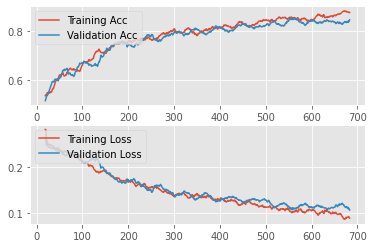

0.94


In [ ]:
import matplotlib.pyplot as plt
from  matplotlib import style
import pandas as pd

style.use("ggplot")

model_name = 'model-1612220848'

def create_acc_loss_graph(model_name):
    contents = open('model.log', 'r').read().split('\n')
    max = 0

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(',')

            if max < float(val_acc):
                max = float(val_acc)
                
            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    valAcc = {'Time' : times, 'Validation Accuracies' : val_accs}
    testAcc =  {'Time' : times, 'Testing Accuracies' : accuracies}
    valLoss = {'Time' : times, 'Validation Losses' : val_losses}
    testLoss = {'Time' : times, 'Testing Losses' : losses}

    dfVA = pd.DataFrame(valAcc)
    dfTA = pd.DataFrame(testAcc)
    dfVL = pd.DataFrame(valLoss)
    dfTL = pd.DataFrame(testLoss)

    for i in range(0,dfVA.shape[0]-2):
      dfVA['valAccAvg'] = dfVA.iloc[:,1].rolling(window=20).mean()
      dfTA['testAccAvg'] = dfTA.iloc[:,1].rolling(window=20).mean()
      dfVL['valLossAvg'] = dfVL.iloc[:,1].rolling(window=20).mean()
      dfTL['testLossAvg'] = dfTL.iloc[:,1].rolling(window=20).mean()
        
    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

    ax1.plot(dfTA['testAccAvg'], label='Training Acc')
    ax1.plot(dfVA['valAccAvg'], label='Validation Acc')
    ax1.legend(loc=2)

    ax2.plot(dfTL['testLossAvg'], label='Training Loss')
    ax2.plot(dfVL['valLossAvg'], label='Validation Loss')
    ax2.legend(loc=2)

    plt.show()
    print(max)

create_acc_loss_graph(model_name)